## **1. Entendimento do Negócio**

**Definição de Objetivos:** Desenvolver um modelo preditivo para estimar os preços futuros de ações específicas (VALE3, PETR4, ITUB4, BBDC4, B3SA3), ajudando investidores e analistas financeiros a tomar decisões informadas.

**Requisitos do Projeto:** O modelo deve ser capaz de prever os preços das ações para qualquer data futura especificada pelo usuário.

**Impacto Esperado:** Facilitar análises de investimento e gestão de riscos com previsões de longo prazo.

###**2. Entendimento dos Dados**

**Coleta de Dados:** Importação dos dados históricos das ações de 2010 a 2023 a partir de arquivos em formatos específicos.

**Exploração e Análise:** Utilização de técnicas avançadas para examinar as séries temporais, identificando tendências, ciclos sazonais e correlações.


***Importação das Bibliotecas***

In [ ]:
import os
import gc
import math
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import dask.dataframe as dd
import statsmodels.api as sm
from google.colab import drive
from scipy.stats import shapiro
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from keras.models import load_model
from dask.diagnostics import ProgressBar
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, MultiHeadAttention, Flatten,  LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2, l2
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, median_absolute_error, explained_variance_score, mean_squared_log_error
from keras import regularizers, initializers
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from datetime import timedelta, datetime
from pandas.tseries.offsets import BDay
from sklearn.linear_model import LinearRegression

***Montar o Google Drive no ambiente Colab***

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Definir o caminho no diretório para ler os arquivos onde estão salvos***

In [ ]:
directory_path = "/content/drive/MyDrive/Colab Notebooks/Base de Treino"

***Definindo as especificações das colunas indicando a posição inicial e final de cada uma***

In [ ]:
 # colspecs = [
 #     (0, 2), (2, 10), (10, 12), (12, 24), (24, 27), (27, 39), (39, 49), (49, 52), (52, 56),
 #     (56, 69), (69, 82), (82, 95), (95, 108), (108, 121), (121, 134), (134, 147), (147, 152),
 #     (152, 170), (170, 188), (188, 201), (201, 202), (202, 210), (210, 217), (217, 230), (230, 242), (242, 245)
 # ]

***Definir o nome da cada uma das colunas do dataframe***

In [ ]:
# col_names = ["Tipo de Registro", "Data do pregão", "Código BDI", "Código de negociação", "Tipo de mercado", "Nome resumido",
#             "Especificação do papel", "Prazo em dias", "Moeda de referência", "Preço de abertura",
#             "Preço máximo", "Preço mínimo", "Preço médio", "Preço do último negócio", "Preço da melhor oferta de compra",
#             "Preço da melhor oferta de venda", "Número de negócios", "Quantidade total de títulos", "Volume total",
#             "Preço de exercício ou valor do contrato", "Indicador de correção", "Data de vencimento",
#             "Fator de cotação", "Preço de exercício em pontos", "Código ISIN ou interno", "Número de distribuição"]

***Código das ações de interesse***

In [ ]:
acoes_interesse = ['VALE3', 'PETR4', 'ITUB4', 'BBDC4', 'B3SA3']

***Criando uma lista vazia para armazenar os Dataframes temporários***

In [ ]:
 #dfs = []

***Criando o dataframe***

In [ ]:
#for filename in os.listdir(directory_path):
#    if filename.startswith('COTAHIST_A'):
#        file_path = os.path.join(directory_path, filename)
#        df = dd.read_fwf(file_path, colspecs=colspecs, names=col_names, dtype=str, encoding='ISO-8859-1')
#        filtered_df = df[(df['Tipo de Registro'] == '01') & df['Código de negociação'].isin(acoes_interesse)]
#        dfs.append(filtered_df)

#final_df = dd.concat(dfs, axis=0)

#with ProgressBar():
#    result = final_df.compute()
#print("DataFrame final criado com sucesso. Total de linhas: ", result.shape[0])


***Caminho para salvar o arquivo csv no google drive***

In [ ]:
# Caminho para salvar o arquivo CSV
output_path = '/content/drive/MyDrive/Colab Notebooks/Base de Treino/final_data.csv'

***Salvando os dados do dataframe em um arquivo de extensão csv***

In [ ]:
#with ProgressBar():
#    final_df.to_csv(output_path, single_file=True, index=False)

#print("DataFrame foi salvo com sucesso no formato CSV em:", output_path)

***Limpando a memória para liberar recursos do sistema***

In [ ]:
# del final_df  # Apaga a referência ao DataFrame do Dask
# gc.collect()  # Executa coleta de lixo para liberar memória

***Definindo o arquivo onde o csv foi salvo***

In [ ]:
csv_path = '/content/drive/MyDrive/Colab Notebooks/Base de Treino/final_data.csv'

***Carregar o arquivo CSV em um DataFrame do Pandas***

In [ ]:
df = pd.read_csv(csv_path)

***Exibir as primeiras linhas do DataFrame para verificar os dados***

In [ ]:
print(df.head())

   Tipo de Registro  Data do pregão  Código BDI Código de negociação  \
0                 1        20100104           2                BBDC4   
1                 1        20100104           2                ITUB4   
2                 1        20100104           2                PETR4   
3                 1        20100104           2                VALE3   
4                 1        20100105           2                BBDC4   

   Tipo de mercado Nome resumido Especificação do papel  Prazo em dias  \
0               10      BRADESCO             PN      N1            NaN   
1               10  ITAUUNIBANCO             PN  EDJ N1            NaN   
2               10     PETROBRAS                 PN  EJ            NaN   
3               10          VALE             ON      N1            NaN   
4               10      BRADESCO             PN  ED  N1            NaN   

  Moeda de referência  Preço de abertura  ...  Número de negócios  \
0                  R$               3685  ...        

***Exibir o tipo de dados contidos em cada uma das colunas do dataframe***

In [ ]:
print(df.dtypes)

Tipo de Registro                             int64
Data do pregão                               int64
Código BDI                                   int64
Código de negociação                        object
Tipo de mercado                              int64
Nome resumido                               object
Especificação do papel                      object
Prazo em dias                              float64
Moeda de referência                         object
Preço de abertura                            int64
Preço máximo                                 int64
Preço mínimo                                 int64
Preço médio                                  int64
Preço do último negócio                      int64
Preço da melhor oferta de compra             int64
Preço da melhor oferta de venda              int64
Número de negócios                           int64
Quantidade total de títulos                  int64
Volume total                                 int64
Preço de exercício ou valor do 

***Mostrar a quantidade de registros nulos e NaN em cada uma das colunas***

In [ ]:
# Calcular o número total de valores NaN em cada coluna
na_counts = df.isna().sum()

# Exibir o número total de valores NaN por coluna
print(na_counts)

Tipo de Registro                               0
Data do pregão                                 0
Código BDI                                     0
Código de negociação                           0
Tipo de mercado                                0
Nome resumido                                  0
Especificação do papel                         0
Prazo em dias                              15295
Moeda de referência                            0
Preço de abertura                              0
Preço máximo                                   0
Preço mínimo                                   0
Preço médio                                    0
Preço do último negócio                        0
Preço da melhor oferta de compra               0
Preço da melhor oferta de venda                0
Número de negócios                             0
Quantidade total de títulos                    0
Volume total                                   0
Preço de exercício ou valor do contrato        0
Indicador de correçã

***Gerar a matriz de correlação e heatmap***

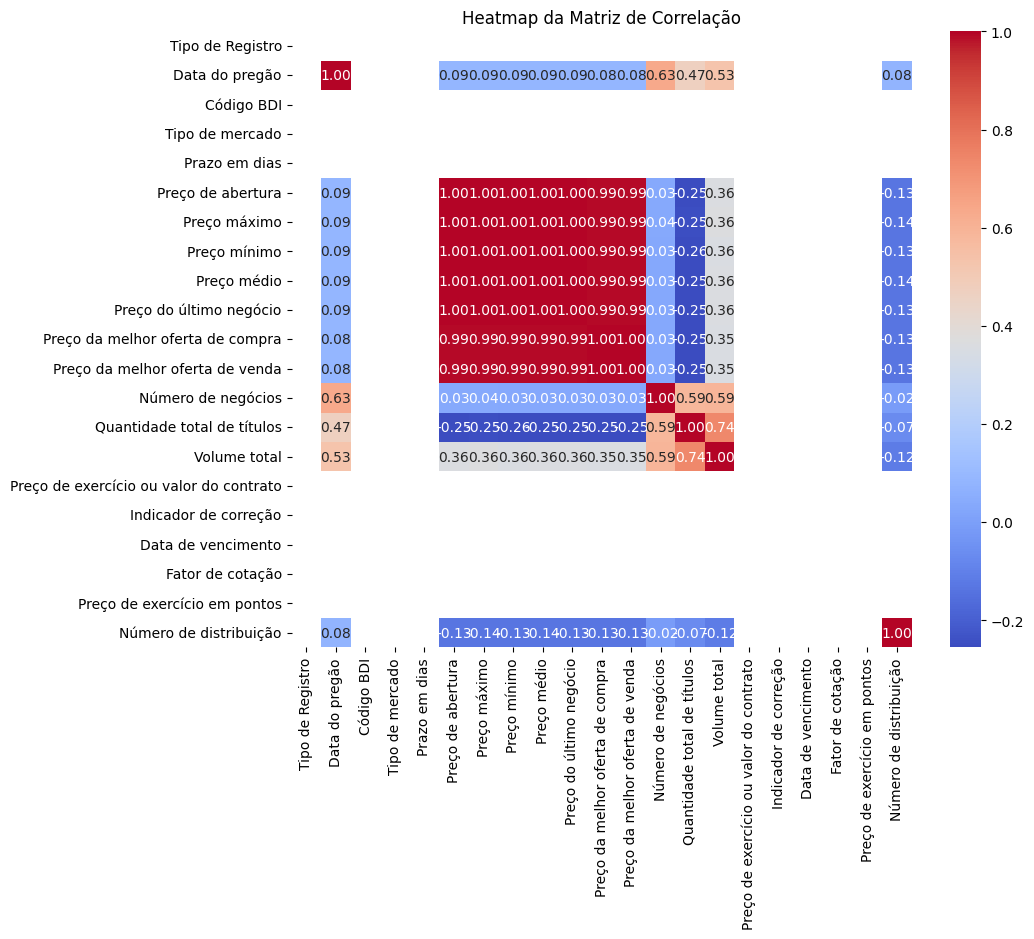

In [ ]:
# Identificar colunas numéricas (exclui automaticamente colunas não numéricas)
df_numeric = df.select_dtypes(include=[np.number])

# Gerar a matriz de correlação somente com colunas numéricas
corr_matrix = df_numeric.corr()

# Criar um heatmap usando Seaborn para visualizar a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Heatmap da Matriz de Correlação')
plt.show()

###**3. Preparação dos Dados**

**Limpeza de Dados:** Remoção de colunas desnecessárias, tratamento de valores ausentes, e conversão de dados para os formatos adequados.

**Engenharia de Atributos:** Criação de variáveis derivadas como médias móveis e indicadores técnicos que podem ser preditivos.
Pré-processamento: Preparação dos dados para serem consumidos pelos modelos, incluindo normalização e padronização quando necessário.

**Visualização de Dados:** Elaboração de gráficos para melhor visualização das tendências históricas, das distribuições dos dados e das transformações aplicadas, auxiliando na verificação da correta preparação dos dados para modelagem.

**Excluir colunas que não são necessárias ao modelo que será criado**

In [ ]:
# Lista de colunas a serem excluídas
columns_to_drop = [
    "Tipo de Registro", "Especificação do papel", "Código BDI", "Tipo de mercado", "Nome resumido", "Prazo em dias",
    "Moeda de referência", "Preço de exercício ou valor do contrato", "Indicador de correção",
    "Data de vencimento", "Fator de cotação", "Preço de exercício em pontos", "Código ISIN ou interno",
    "Número de distribuição"
]

# Excluindo as colunas do DataFrame
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)

**Exibir as colunas que permaneceram no dataframe e o tipo de cada um dos dados**

In [ ]:
print(df.dtypes)

Data do pregão                       int64
Código de negociação                object
Preço de abertura                    int64
Preço máximo                         int64
Preço mínimo                         int64
Preço médio                          int64
Preço do último negócio              int64
Preço da melhor oferta de compra     int64
Preço da melhor oferta de venda      int64
Número de negócios                   int64
Quantidade total de títulos          int64
Volume total                         int64
dtype: object


**Alterar o tipo dos dados das colunas**



In [ ]:
# Converter 'Data do pregão' para datetime
df['Data do pregão'] = pd.to_datetime(df['Data do pregão'], format='%Y%m%d')  # Ajuste o formato conforme necessário

# Lista de colunas para converter para numérico e dividir por 100
columns_to_convert = [
    'Preço de abertura', 'Preço máximo', 'Preço mínimo', 'Preço médio',
    'Preço do último negócio', 'Preço da melhor oferta de compra',
    'Preço da melhor oferta de venda', 'Volume total'
]

# Converter colunas para numérico e ajustar
for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')  # Convertendo para numérico
    df[column] = df[column] / 100  # Dividindo por 100

**Exibindo os dados após a mudança**

In [ ]:
# Exibir os tipos de dados para confirmar as mudanças
print(df.dtypes)

Data do pregão                      datetime64[ns]
Código de negociação                        object
Preço de abertura                          float64
Preço máximo                               float64
Preço mínimo                               float64
Preço médio                                float64
Preço do último negócio                    float64
Preço da melhor oferta de compra           float64
Preço da melhor oferta de venda            float64
Número de negócios                           int64
Quantidade total de títulos                  int64
Volume total                               float64
dtype: object


**Exibir as primeiras linhas para verificar as mudanças**


In [ ]:
print(df.head())

  Data do pregão Código de negociação  Preço de abertura  Preço máximo  \
0     2010-01-04                BBDC4              36.85         37.93   
1     2010-01-04                ITUB4              38.89         40.49   
2     2010-01-04                PETR4              36.95         37.32   
3     2010-01-04                VALE3              50.19         51.49   
4     2010-01-05                BBDC4              37.90         38.04   

   Preço mínimo  Preço médio  Preço do último negócio  \
0         36.80        37.57                    37.70   
1         38.89        39.96                    40.12   
2         36.82        37.10                    37.32   
3         49.80        50.85                    51.49   
4         36.96        37.42                    37.50   

   Preço da melhor oferta de compra  Preço da melhor oferta de venda  \
0                             37.70                            37.88   
1                             40.12                            40.15

**Pesquisar por Outliers por meio de BoxPlots**

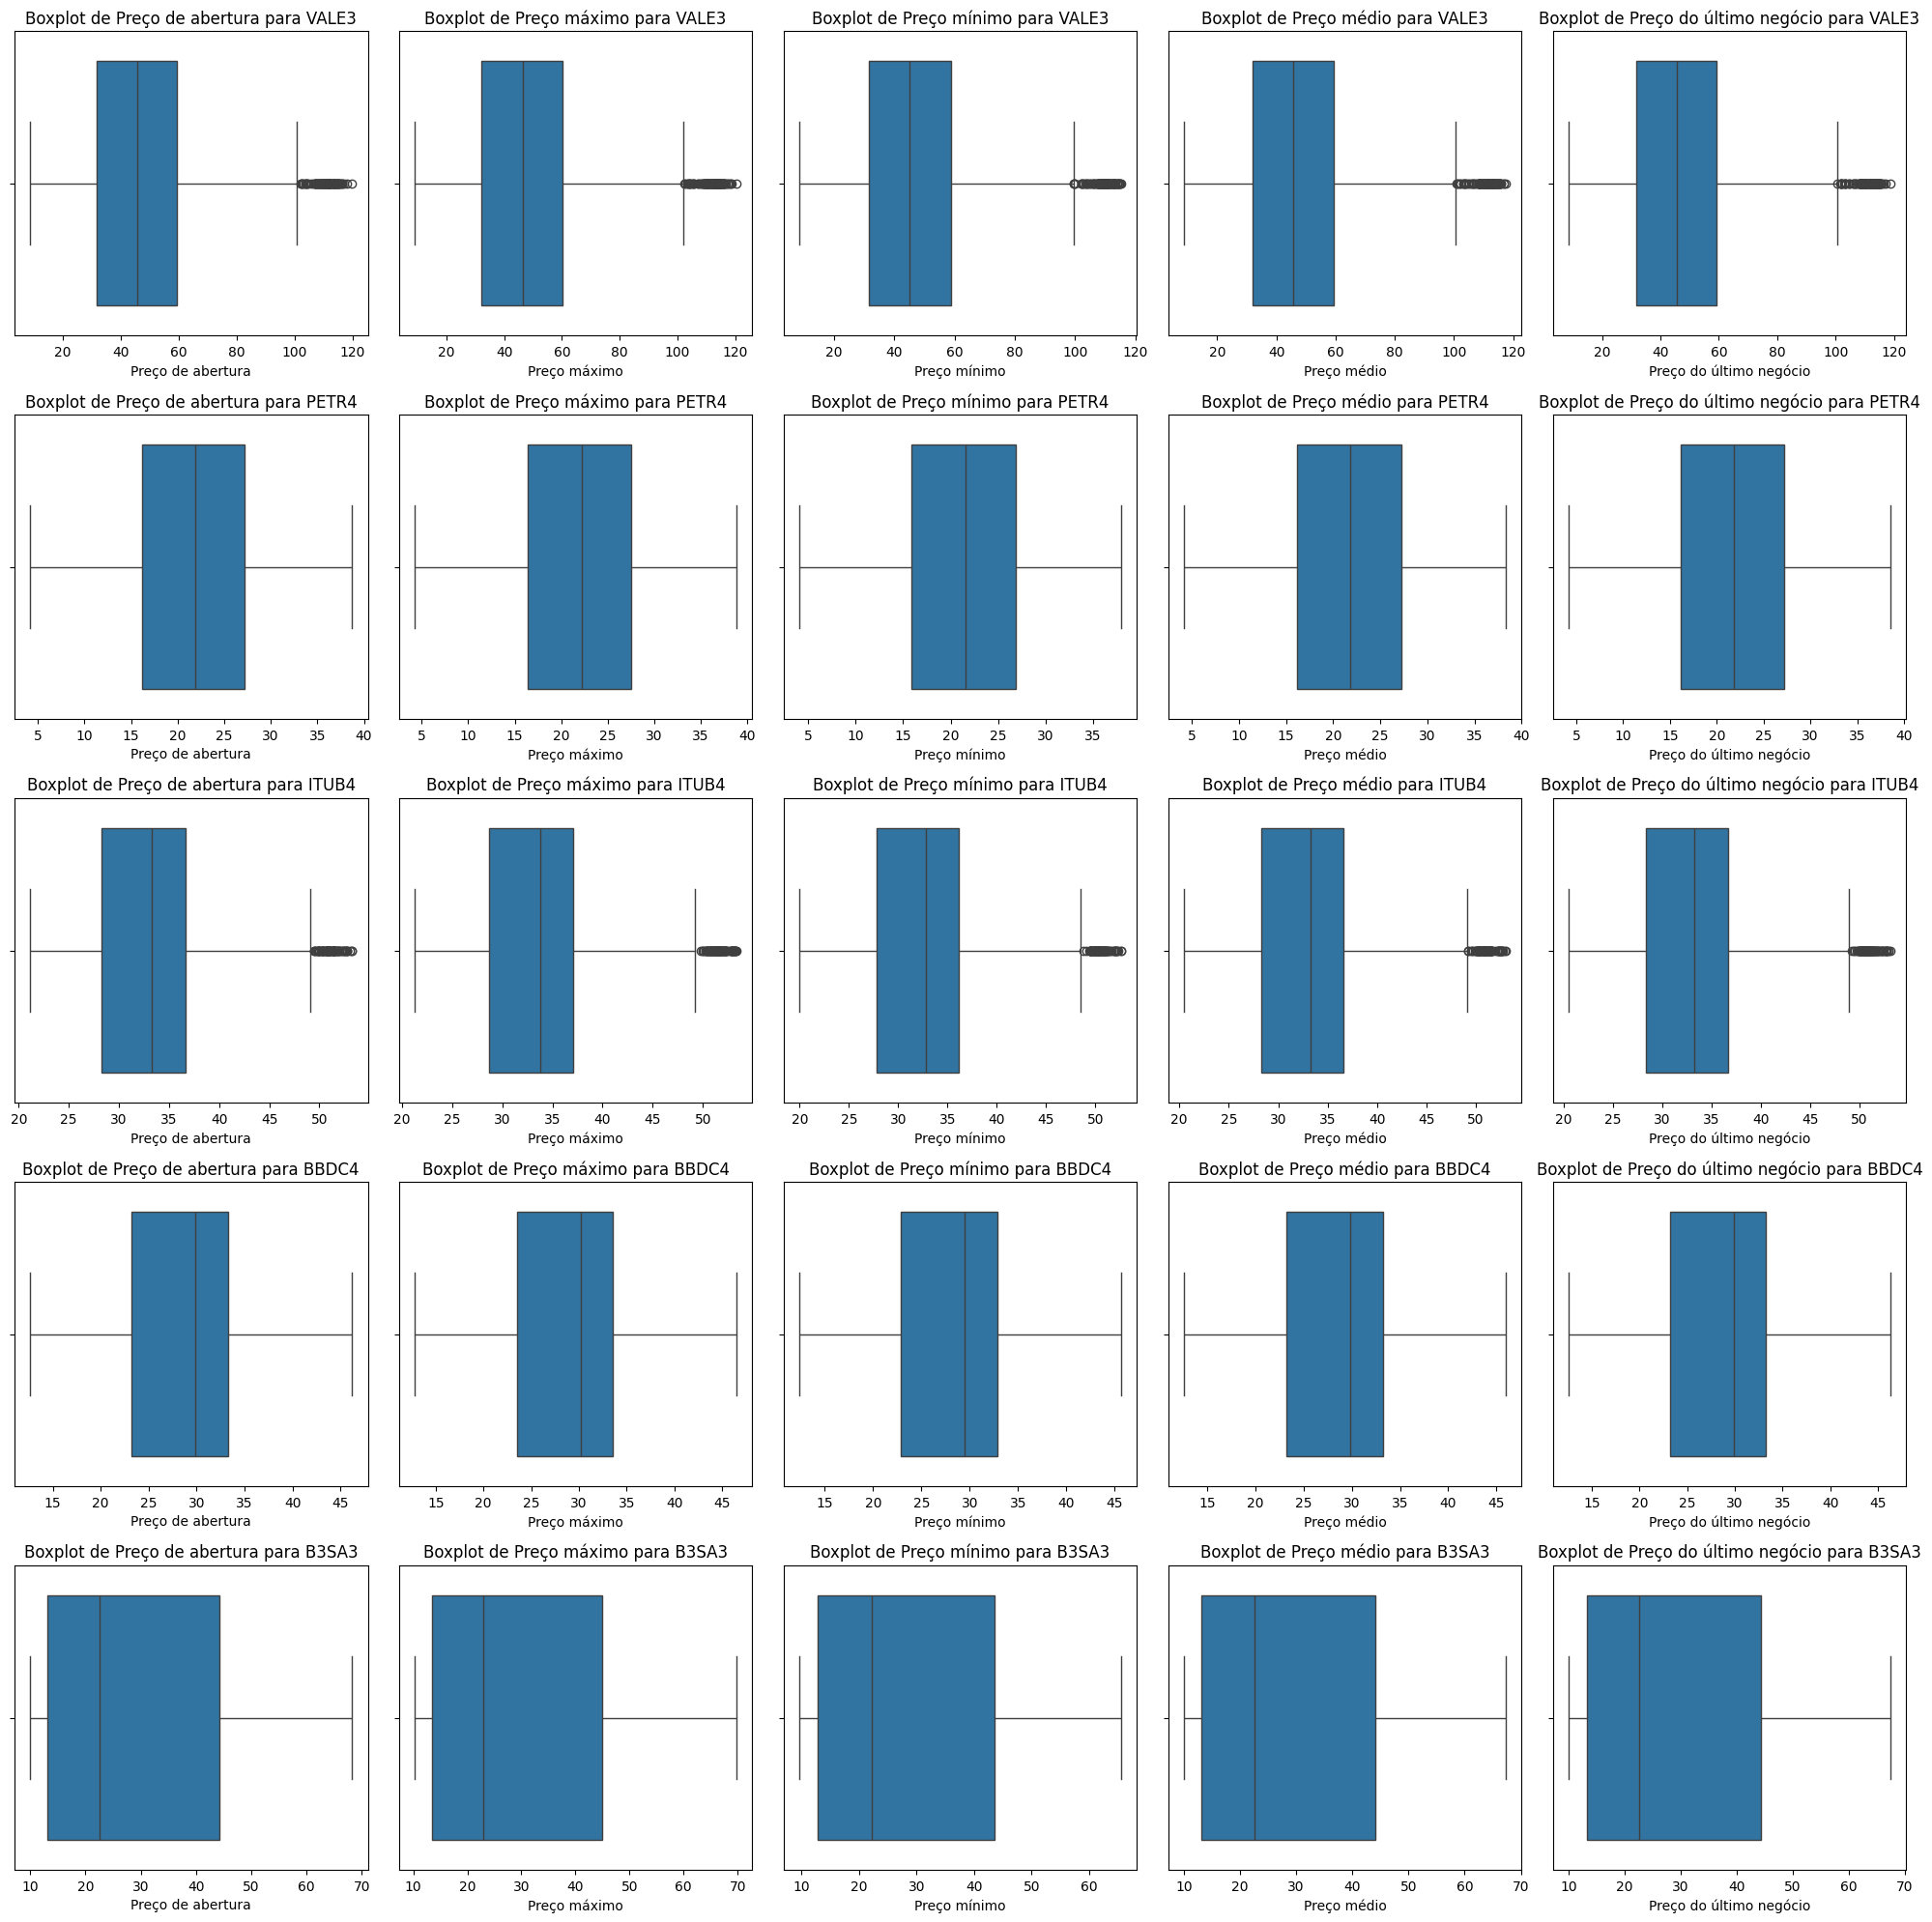

In [ ]:
# Configurando os boxplots para todas as colunas de valores para cada uma das ações
fig, axes = plt.subplots(nrows=len(acoes_interesse), ncols=5, figsize=(20, 20))  # 5 colunas para Preço de Abertura, Máximo, Mínimo, Médio, Último Negócio

# Colunas de interesse para boxplot
preco_cols = ['Preço de abertura', 'Preço máximo', 'Preço mínimo', 'Preço médio', 'Preço do último negócio']

for i, codigo in enumerate(acoes_interesse):
    df_acao = df[df['Código de negociação'] == codigo]

    for j, col in enumerate(preco_cols):
        sns.boxplot(x=df_acao[col], ax=axes[i, j])
        axes[i, j].set_title(f'Boxplot de {col} para {codigo}')
        axes[i, j].set_xlabel(col)

plt.tight_layout()
plt.show()

**Análise dos Boxplots:**

**Variação de Preços:**

* Todos os boxplots apresentam variações significativas nos preços, com alguns dias mostrando valores extremamente altos ou baixos, representados pelos outliers nos gráficos.
* Os outliers em preços máximos e mínimos são particularmente notáveis, sugerindo dias com volatilidade excepcional.

**Consistência entre as Ações:**

* Algumas ações, como PETR4 e VALE3, mostram uma quantidade maior de outliers em comparação com outras, o que pode indicar uma maior volatilidade nessas ações devido a fatores setoriais ou eventos de mercado específicos.

**Tendências Gerais:**

* Em geral, os boxplots indicam que o preço médio segue de perto os preços de abertura e de fechamento, o que é esperado, mas os extremos (outliers) podem fornecer insights sobre comportamentos anormais do mercado em dias específicos.

**Conclusões:**

* **Volatilidade e Risco:** A presença de numerosos outliers em todos os tipos de preço sugere alta volatilidade, o que pode representar maior risco para investidores. Esta análise pode ajudar a identificar as ações com maiores flutuações de preços, o que pode ser útil para estratégias de trading que capitalizam na volatilidade.
* **Análise de Eventos de Mercado:** Os outliers nos boxplots podem ser correlacionados a eventos de mercado, como anúncios econômicos, mudanças regulatórias, ou desenvolvimentos significativos nas empresas. Uma análise mais aprofundada desses dias pode revelar as causas da volatilidade excepcional.
* **Ferramentas para Decisão de Investimento:**
Estes boxplots fornecem uma ferramenta valiosa para os investidores ao avaliar quais ações têm maior variabilidade nos preços e podem exigir estratégias de mitigação de risco mais robustas, como diversificação ou uso de derivativos para hedge.

**Análise de Outliers por meio de Isolation Forest**

In [ ]:
# Definindo os parâmetros do Isolation Forest
n_estimators = 100  # Número de árvores no Isolation Forest
contamination = 'auto'  # Proporção de outliers esperada no conjunto de dados, pode ajustar conforme necessário

# Aplicando o Isolation Forest para todas as ações e coletando os resultados de outliers
all_outliers_iforest = {}

for codigo in acoes_interesse:
    df_acao = df[df['Código de negociação'] == codigo]

    # Preparando os dados
    X = df_acao[['Preço de abertura', 'Preço máximo', 'Preço mínimo', 'Preço médio', 'Volume total']].dropna()

    # Criando e ajustando o modelo Isolation Forest
    iforest_model = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=42)
    preds = iforest_model.fit_predict(X)

    # Identificando os outliers
    df_acao['Outlier'] = preds  # Marcando os outliers no DataFrame original
    outliers = df_acao[df_acao['Outlier'] == -1]
    all_outliers_iforest[codigo] = outliers

# Exibindo um resumo dos resultados para cada ação
for codigo, data in all_outliers_iforest.items():
    print(f"Outliers identificados para {codigo}: {len(data)} registros.")

<ipython-input-24-bcbcc2b1477b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acao['Outlier'] = preds  # Marcando os outliers no DataFrame original
<ipython-input-24-bcbcc2b1477b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acao['Outlier'] = preds  # Marcando os outliers no DataFrame original
<ipython-input-24-bcbcc2b1477b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

Outliers identificados para VALE3: 822 registros.
Outliers identificados para PETR4: 792 registros.
Outliers identificados para ITUB4: 703 registros.
Outliers identificados para BBDC4: 789 registros.
Outliers identificados para B3SA3: 472 registros.


<ipython-input-24-bcbcc2b1477b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acao['Outlier'] = preds  # Marcando os outliers no DataFrame original


O Isolation Forest foi aplicado às séries históricas de preços e volumes de negociação para as ações VALE3, PETR4, ITUB4, BBDC4 e B3SA3, e os seguintes resultados foram obtidos:

* VALE3: 822 registros classificados como outliers.
* PETR4: 792 registros classificados como outliers.
* ITUB4: 703 registros classificados como outliers.
* BBDC4: 789 registros classificados como outliers.
* B3SA3: 472 registros classificados como outliers.

**Conclusões Gerais**

* **Presença de Outliers:** Todas as ações apresentaram uma quantidade significativa de outliers, indicando dias com atividades de preços ou volumes de negociação que diferem substancialmente do comportamento típico.
* **Volatilidade e Eventos de Mercado:** O número de outliers pode refletir a volatilidade das ações e a sensibilidade a eventos de mercado específicos. Ações com mais outliers podem ser mais voláteis e, possivelmente, mais afetadas por eventos externos ou anúncios internos da empresa.
* **Análise Detalhada Necessária:** Cada outlier pode ser um ponto de partida para uma análise mais detalhada para entender os eventos ou as condições de mercado que causaram essas anomalias. Isso pode incluir a revisão de notícias, relatórios financeiros, ou mudanças macroeconômicas no período correspondente.
* **Implicações para Investidores e Analistas:** Investidores e analistas devem considerar a presença de outliers ao desenvolver estratégias de investimento ou ao realizar avaliações de risco. Ações com frequência alta de outliers podem requerer abordagens de gestão de risco mais robustas.
* **Potencial para Estratégias de Trading:** Identificar padrões nos dias que levaram a outliers pode oferecer oportunidades de trading, especialmente para estratégias que capitalizam sobre volatilidade ou movimentos de preços abruptos.

**Analise de Outliers pelo método IQR**

In [ ]:
# Função para identificar outliers usando o método IQR
def identify_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# Aplicando o método IQR para cada ação e cada coluna de preço
iqr_outliers_results = {}

for codigo in acoes_interesse:
    df_acao = df[df['Código de negociação'] == codigo]
    iqr_outliers_results[codigo] = {}

    for col in preco_cols:
        outliers = identify_outliers_iqr(df_acao[col])
        iqr_outliers_results[codigo][col] = outliers

# Exibindo os resultados para cada ação
for codigo, outliers_info in iqr_outliers_results.items():
    print(f"Outliers para {codigo} por IQR:")
    for col, outliers in outliers_info.items():
        print(f"{col}: {len(outliers)} outliers encontrados")
    print("\n")  # Espaçamento entre as ações para clareza

Outliers para VALE3 por IQR:
Preço de abertura: 99 outliers encontrados
Preço máximo: 101 outliers encontrados
Preço mínimo: 99 outliers encontrados
Preço médio: 100 outliers encontrados
Preço do último negócio: 102 outliers encontrados


Outliers para PETR4 por IQR:
Preço de abertura: 0 outliers encontrados
Preço máximo: 0 outliers encontrados
Preço mínimo: 0 outliers encontrados
Preço médio: 0 outliers encontrados
Preço do último negócio: 0 outliers encontrados


Outliers para ITUB4 por IQR:
Preço de abertura: 81 outliers encontrados
Preço máximo: 84 outliers encontrados
Preço mínimo: 78 outliers encontrados
Preço médio: 81 outliers encontrados
Preço do último negócio: 82 outliers encontrados


Outliers para BBDC4 por IQR:
Preço de abertura: 0 outliers encontrados
Preço máximo: 0 outliers encontrados
Preço mínimo: 0 outliers encontrados
Preço médio: 0 outliers encontrados
Preço do último negócio: 0 outliers encontrados


Outliers para B3SA3 por IQR:
Preço de abertura: 0 outliers enco

**VALE3:** Outliers encontrados em todas as colunas de preço, com aproximadamente 100 outliers em cada uma, indicando uma certa volatilidade nos preços.

**PETR4:** Não foram encontrados outliers em nenhuma das colunas de preço, sugerindo uma estabilidade maior nos preços durante o período analisado.

**ITUB4:** Similar à VALE3, apresenta uma quantidade significativa de outliers em todas as colunas de preço, mostrando volatilidade.

**BBDC4 e B3SA3:** Não foram detectados outliers em nenhuma das colunas de preço, indicando uma estabilidade nos preços ao longo do tempo analisado.

**Conclusões Gerais**

* **Volatilidade:** VALE3 e ITUB4 mostraram uma quantidade significativa de outliers, o que pode refletir maior volatilidade ou períodos de grandes flutuações de preços, possivelmente influenciados por eventos de mercado ou mudanças nas condições econômicas.
* **Estabilidade:** PETR4, BBDC4 e B3SA3 mostraram poucos ou nenhum outlier, indicando maior estabilidade nos preços. Isso pode ser um sinal de menos risco associado a essas ações do ponto de vista de flutuações extremas de preços.
Implicações para Investidores
* **Gestão de Risco:** Ações como VALE3 e ITUB4 podem requerer estratégias de gestão de risco mais robustas devido à sua maior volatilidade.
Oportunidades de Investimento: A volatilidade refletida pelos outliers pode oferecer oportunidades para investidores e traders que procuram capitalizar em movimentos de preço significativos.
* **Análise Detalhada:** Para investimentos estratégicos, pode ser benéfico investigar os dias específicos associados a esses outliers para entender melhor as causas das flutuações extremas e planejar ações futuras.

**Analise Descritiva dos Dados**

In [ ]:
# Loop para aplicar describe para cada ação
for codigo in acoes_interesse:
    print(f"Descrição Estatística para a ação: {codigo}")
    # Filtrando o DataFrame para o código de negociação atual
    df_acao = df[df['Código de negociação'] == codigo]
    # Aplicando describe para colunas selecionadas
    descricao = df_acao[['Preço de abertura', 'Preço máximo', 'Preço mínimo', 'Preço médio', 'Preço do último negócio', 'Preço da melhor oferta de compra', 'Preço da melhor oferta de venda', 'Número de negócios', 'Quantidade total de títulos', 'Volume total']].describe()
    print(descricao)
    print("\n" + "-"*100 + "\n")  # Apenas para melhorar a legibilidade entre os outputs

Descrição Estatística para a ação: VALE3
       Preço de abertura  Preço máximo  Preço mínimo  Preço médio  \
count        3466.000000   3466.000000   3466.000000  3466.000000   
mean           48.466079     49.087718     47.797398    48.430248   
std            23.117601     23.333663     22.855150    23.093921   
min             8.750000      9.060000      8.600000     8.840000   
25%            31.800000     32.142500     31.432500    31.790000   
50%            45.740000     46.350000     45.140000    45.715000   
75%            59.485000     60.167500     58.737500    59.360000   
max           119.800000    120.450000    115.250000   117.460000   

       Preço do último negócio  Preço da melhor oferta de compra  \
count              3466.000000                       3466.000000   
mean                 48.424700                         48.298658   
std                  23.099496                         23.113164   
min                   8.600000                          0.000000 

**VALE3 (Vale S.A.)**

* **Volatilidade e Preços:** A VALE3 mostra uma ampla faixa de preços de abertura entre R\\$ 8,75 e R\\$ 119,80, indicando uma volatilidade significativa ao longo do tempo. O desvio padrão alto nos preços de abertura (R\\$ 23,12) confirma essa volatilidade.

* **Volume de Negociação:** O volume de negociações varia substancialmente, com a média diária de negócios em torno de 29.225, o que reflete a alta liquidez da ação.

* **Preço Médio:** O preço médio tendeu a seguir de perto os preços de abertura e fechamento, sugerindo menos variação intra-dia comparativamente ao intervalo de longo prazo.

**PETR4 (Petrobras)**

* **Variação de Preço:** Os preços mostram menor amplitude do que a VALE3, com a abertura variando de R\\$ 4,20 a R\\$ 38,69. A consistência entre o preço médio e o último preço negociado indica uma estabilidade razoável durante as sessões de negociação.

* **Volume de Negociação:** PETR4 tem um volume de negociação maior do que VALE3, com cerca de 50,75 milhões de títulos negociados em média por dia, refletindo sua popularidade e liquidez no mercado.
ITUB4 (Itaú Unibanco)

* **Preços Estáveis:** ITUB4 mostra uma variação de preço relativamente estável em comparação com VALE3 e PETR4. O desvio padrão de cerca de R$ 6,00 nos preços sugere menor volatilidade.

* **Número de Negócios:** O número médio de negócios é de 31.724, indicando liquidez sólida, mas menos do que PETR4.

**BBDC4 (Banco Bradesco)**

* **Amplitude de Preço:** Similar a ITUB4 em termos de amplitude de preços e volatilidade, indicando um perfil de risco semelhante.

* **Número de Negócios e Volume:** A quantidade de negócios é comparável à de ITUB4, com um volume total negociado também próximo, o que é típico para grandes bancos listados no Brasil.

**B3SA3 (B3 - Brasil, Bolsa, Balcão)**

* **Distribuição de Preços:** A ação tem uma distribuição de preço significativamente ampla e alta volatilidade, como indicado pelos preços de abertura que variam de R\$ 10,07 a R\$ 68,15.

* **Volume e Negócios:** Possui um número de negócios e volume consideravelmente alto, o que pode ser atribuído ao seu papel central no mercado financeiro brasileiro.

**ITUB4 (Itaú Unibanco)**

* **Amplitude de Preços:** ITUB4 apresenta uma faixa de preços de abertura variando de R\$ 21,17 a R\$ 53,23. A amplitude dos preços máximo e mínimo segue a mesma tendência, indicando que, embora a ação exiba alguma volatilidade, ela permanece dentro de um espectro que sugere uma certa estabilidade em comparação com outras ações mais voláteis no mercado.

* **Preços Médios Consistentes:** O preço médio e o último preço negociado são muito próximos dos valores de abertura e fechamento, indicando pouca variação intra-dia em relação ao intervalo maior.

* **Desvio Padrão:** O desvio padrão em torno de 6 para preços de abertura, máximo, mínimo e médio mostra uma volatilidade moderada. Essa volatilidade é consistente em todos os aspectos dos preços, sugerindo que, enquanto existem flutuações, elas não são extremas.

* **Número de Negócios:** Com uma média de cerca de 31.724 negócios e um pico de até 99.849 negócios, a ação mostra alta liquidez. A alta liquidez é crucial para investidores que buscam entrar ou sair de posições sem impactar significativamente o preço da ação.

* **Quantidade de Títulos Negociados:** A média de mais de 18 milhões de títulos negociados, com um máximo de cerca de 160 milhões, reforça a alta liquidez e o interesse ativo do mercado nessa ação.

**Analise de Tendência**

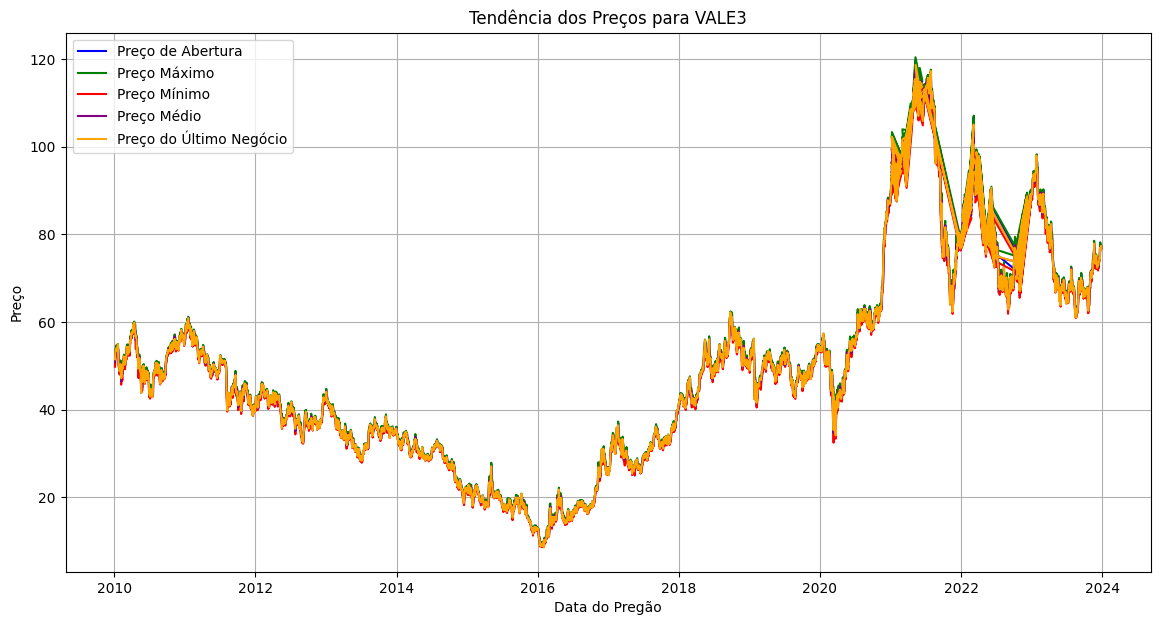

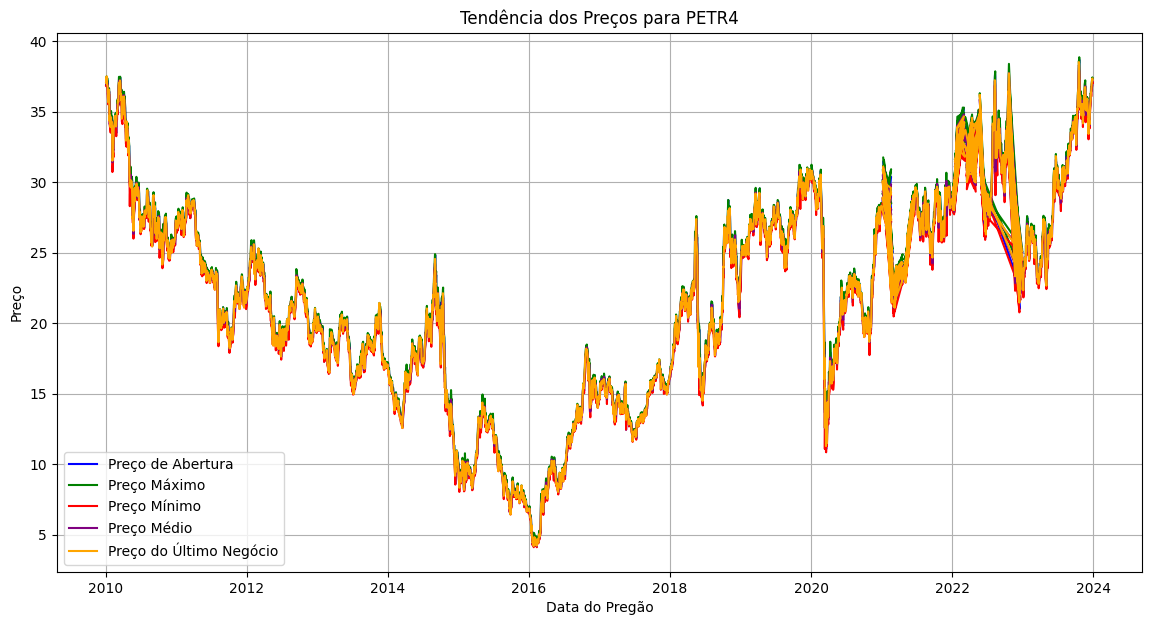

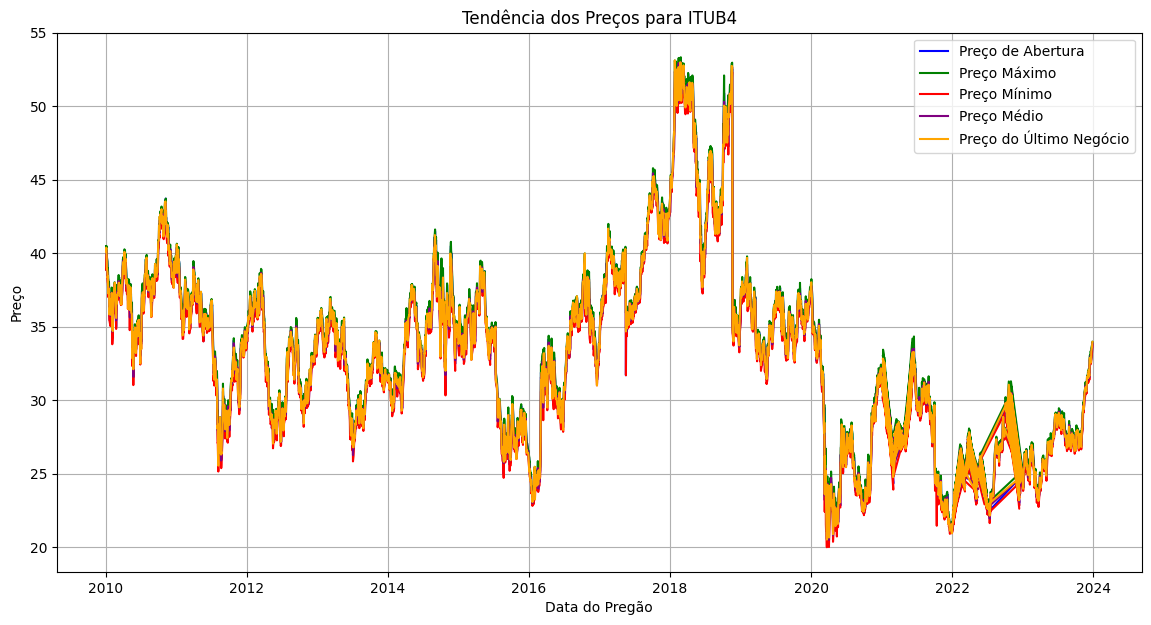

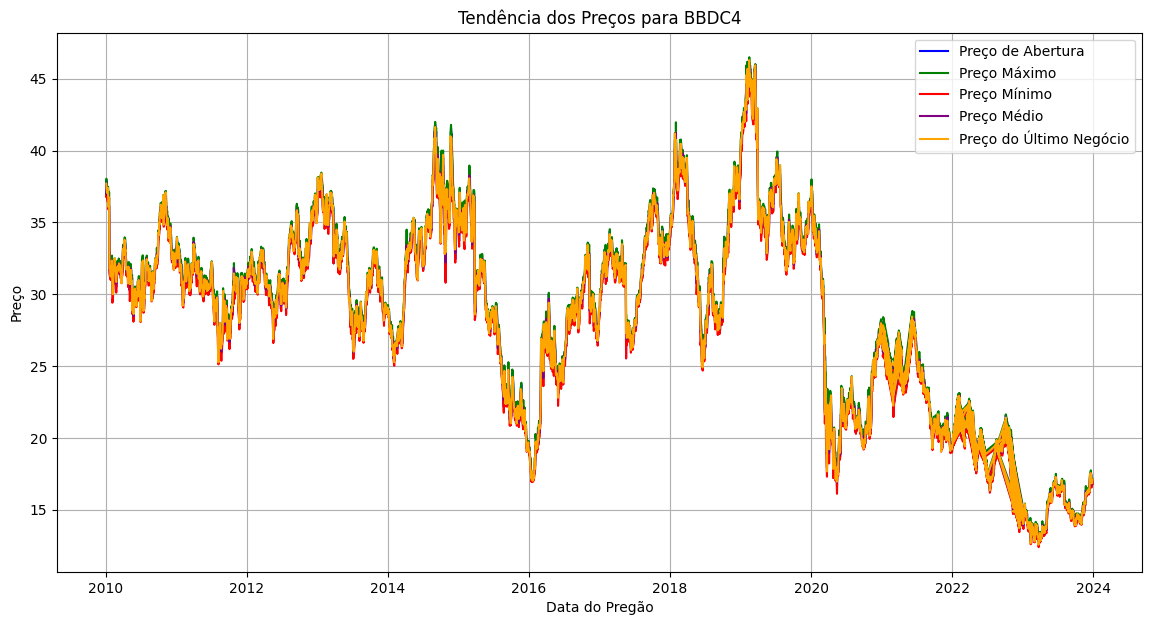

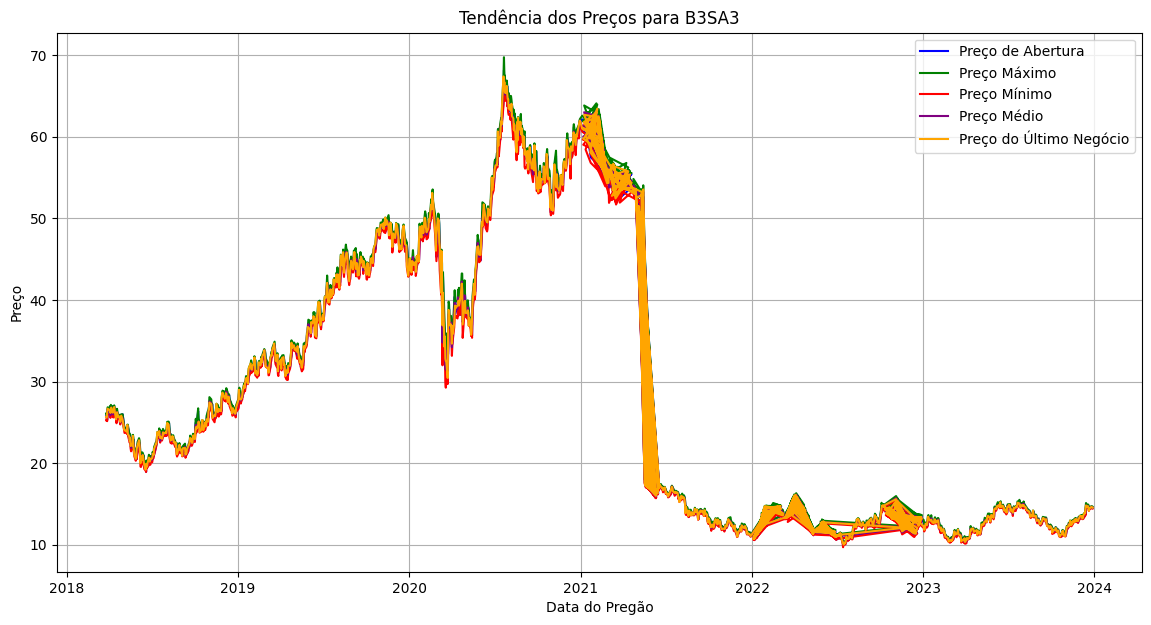

In [ ]:
# Lista dos códigos de negociação das ações de interesse
acoes_interesse = ['VALE3', 'PETR4', 'ITUB4', 'BBDC4', 'B3SA3']

for codigo in acoes_interesse:
    # Filtrar o DataFrame para a ação atual
    df_acao = df[df['Código de negociação'] == codigo]

    # Criar um gráfico de linha para cada preço
    plt.figure(figsize=(14, 7))
    plt.plot(df_acao['Data do pregão'], df_acao['Preço de abertura'], label='Preço de Abertura', color='blue')
    plt.plot(df_acao['Data do pregão'], df_acao['Preço máximo'], label='Preço Máximo', color='green')
    plt.plot(df_acao['Data do pregão'], df_acao['Preço mínimo'], label='Preço Mínimo', color='red')
    plt.plot(df_acao['Data do pregão'], df_acao['Preço médio'], label='Preço Médio', color='purple')
    plt.plot(df_acao['Data do pregão'], df_acao['Preço do último negócio'], label='Preço do Último Negócio', color='orange')

    # Adicionar título e rótulos
    plt.title(f'Tendência dos Preços para {codigo}')
    plt.xlabel('Data do Pregão')
    plt.ylabel('Preço')
    plt.legend()
    plt.grid(True)
    plt.show()

* **Baixa Volatilidade:** Quando os preços de abertura, máximo, mínimo e fechamento são semelhantes, isso geralmente indica baixa volatilidade no mercado para essa ação específica no período observado. A baixa volatilidade pode sugerir que a ação está em um período de estabilidade, com consenso geral entre compradores e vendedores sobre o preço.

* **Liquidez Equilibrada:** Se não há grandes variações de preço ao longo do dia, isso também pode indicar que a ação possui boa liquidez, com transações suficientes para manter o preço estável.

* **Demanda Estável:** A falta de picos ou quedas acentuadas pode refletir uma demanda consistente e uma oferta equilibrada, evitando grandes oscilações de preços.

* **Percepções Alinhadas:** A proximidade entre os preços de abertura e fechamento pode significar que as percepções dos investidores sobre o valor justo da ação não mudaram significativamente durante o dia. Isso pode ser interpretado como um sinal de confiança ou de falta de notícias disruptivas que poderiam afetar a percepção do mercado.

**Análise de Volatilidade**

<ipython-input-28-65ad7eac7e2f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acao['Variação Diária %'] = df_acao['Preço máximo'].sub(df_acao['Preço mínimo']).div(df_acao['Preço mínimo'])*100
<ipython-input-28-65ad7eac7e2f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acao['Variação Diária %'] = df_acao['Preço máximo'].sub(df_acao['Preço mínimo']).div(df_acao['Preço mínimo'])*100
<ipython-input-28-65ad7eac7e2f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

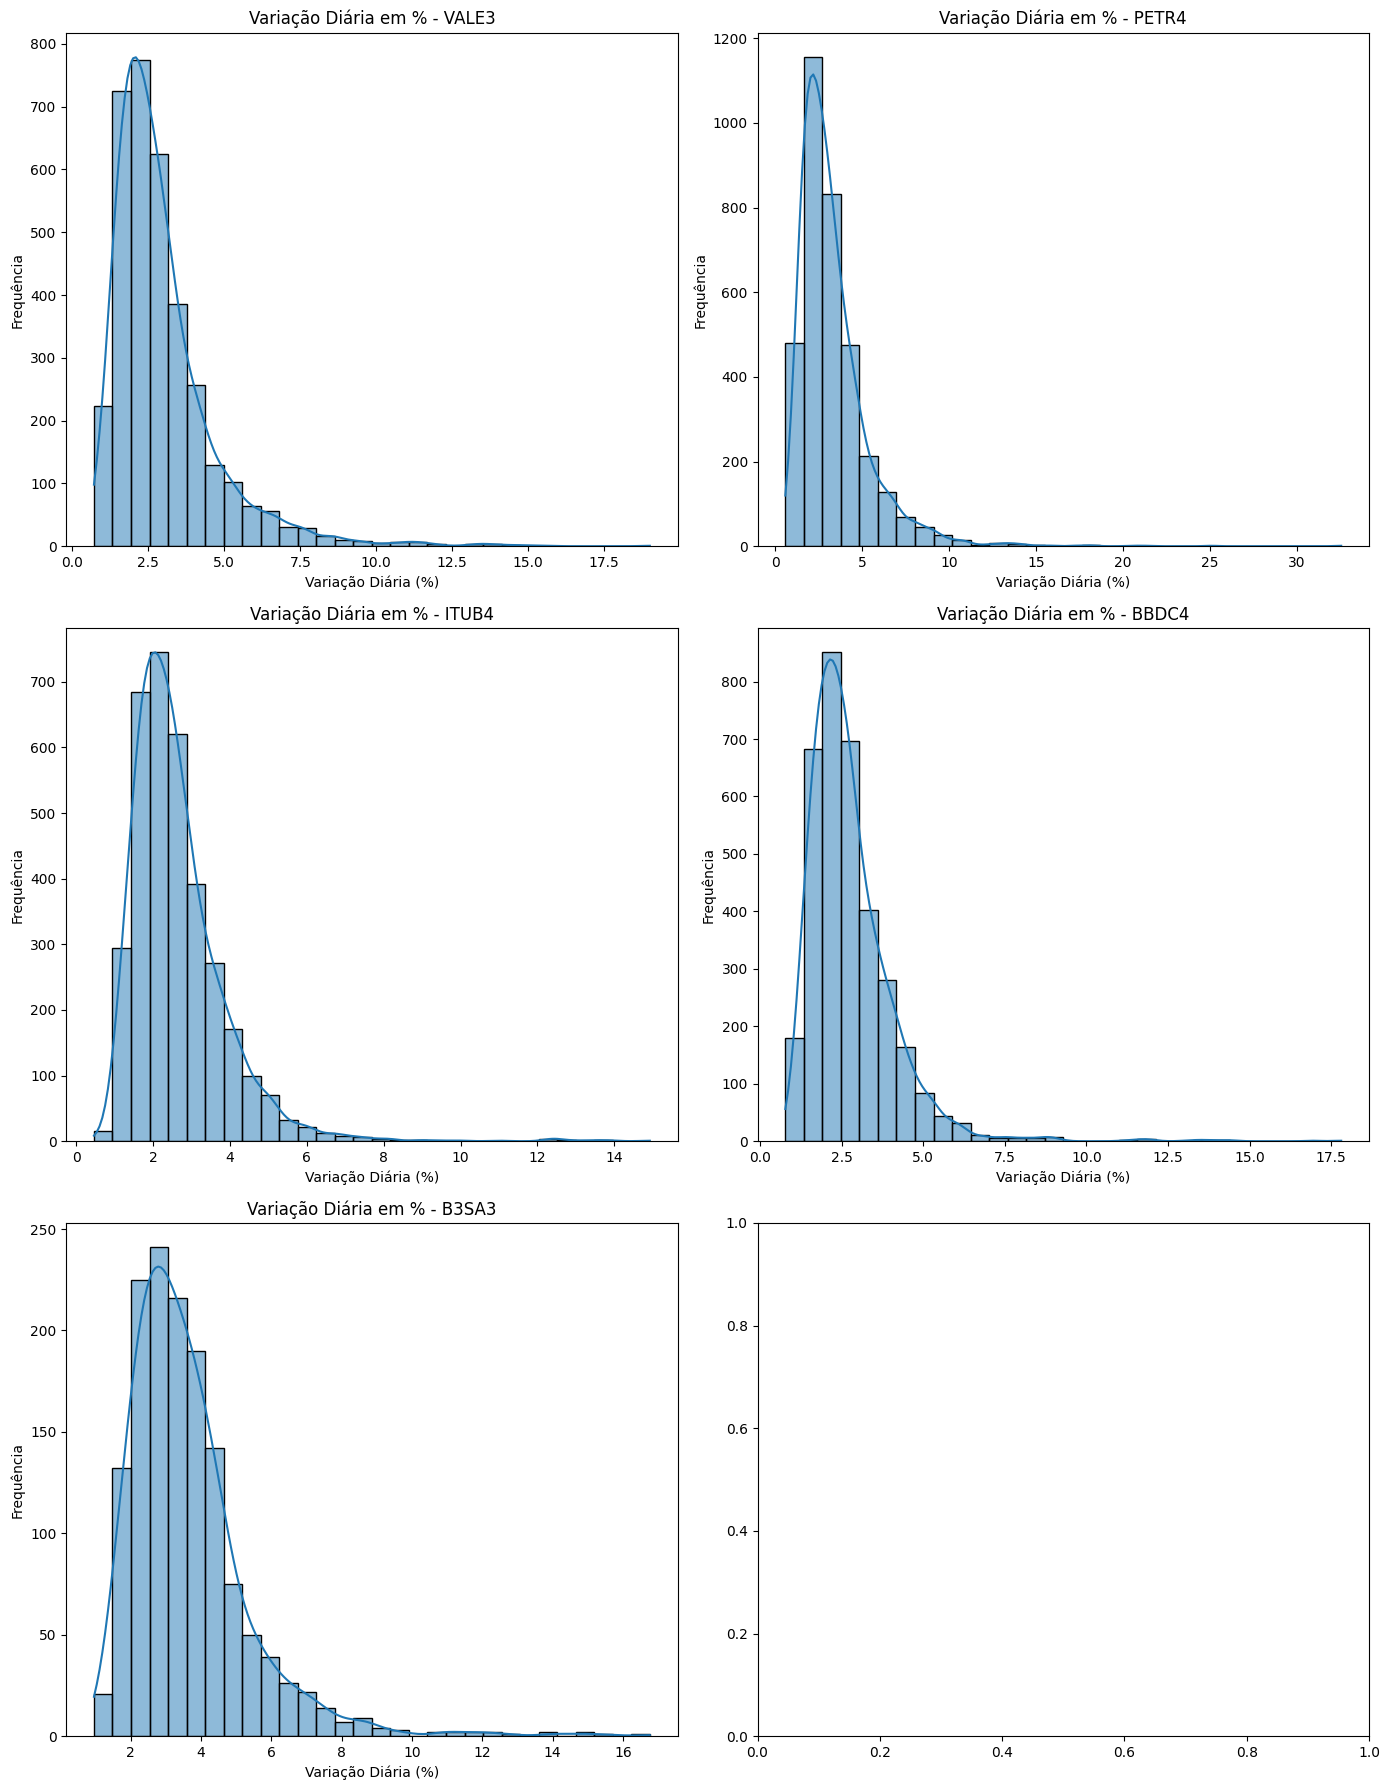

In [ ]:
# Criar um gráfico de barras para cada ação mostrando a variação diária média e o desvio padrão

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))
axes = axes.flatten()  # Transforma o array de axes em 1D para facilitar o acesso

for index, codigo in enumerate(acoes_interesse):
    # Filtrar o DataFrame para a ação atual
    df_acao = df[df['Código de negociação'] == codigo]

    # Calcular a variação diária em percentual
    df_acao['Variação Diária %'] = df_acao['Preço máximo'].sub(df_acao['Preço mínimo']).div(df_acao['Preço mínimo'])*100

    # Plotar o gráfico
    sns.histplot(df_acao['Variação Diária %'], bins=30, kde=True, ax=axes[index])
    axes[index].set_title(f'Variação Diária em % - {codigo}')
    axes[index].set_xlabel('Variação Diária (%)')
    axes[index].set_ylabel('Frequência')

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()

* **VALE3 e B3SA3** mostram distribuições com caudas mais longas para o lado direito, indicando dias com variações percentuais maiores que são menos frequentes, mas significativas. Isto sugere uma volatilidade ocasionalmente alta, que pode representar um risco maior para investidores.
* **PETR4** tem a distribuição mais larga com a cauda mais longa, refletindo sua maior volatilidade e desvio padrão entre as ações analisadas. Este comportamento é consistente com o desvio padrão mais alto encontrado (2.08), o que indica um risco mais elevado, mas também potencial para ganhos rápidos.
* **ITUB4 e BBDC4** apresentam distribuições mais concentradas e simétricas, com desvios padrões menores (1.25 e 1.34, respectivamente). Isso sugere uma volatilidade mais baixa, o que pode ser mais adequado para investidores que preferem menos risco.

In [ ]:
# Calcular a variação diária percentual para cada ação e extrair estatísticas descritivas
for codigo in acoes_interesse:
    # Filtrar o DataFrame para a ação atual
    df_acao = df[df['Código de negociação'] == codigo]

    # Calcular a variação diária em percentual
    df_acao['Variação Diária %'] = df_acao['Preço máximo'].sub(df_acao['Preço mínimo']).div(df_acao['Preço mínimo']) * 100

    # Calcular estatísticas descritivas da variação diária percentual
    descricao = df_acao['Variação Diária %'].describe()

    # Imprimir as estatísticas
    print(f"Estatísticas de volatilidade para {codigo}:")
    print(descricao)
    print("\n" + "-"*50 + "\n")  # Separador para melhor legibilidade

Estatísticas de volatilidade para VALE3:
count    3466.000000
mean        2.972617
std         1.728776
min         0.709750
25%         1.877333
50%         2.543181
75%         3.478113
max        19.000000
Name: Variação Diária %, dtype: float64

--------------------------------------------------

Estatísticas de volatilidade para PETR4:
count    3466.000000
mean        3.331466
std         2.078980
min         0.590468
25%         1.999278
50%         2.835105
75%         4.025958
max        32.550336
Name: Variação Diária %, dtype: float64

--------------------------------------------------

Estatísticas de volatilidade para ITUB4:
count    3466.000000
mean        2.644811
std         1.253387
min         0.462453
25%         1.827684
50%         2.385756
75%         3.130231
max        14.926004
Name: Variação Diária %, dtype: float64

--------------------------------------------------

Estatísticas de volatilidade para BBDC4:
count    3466.000000
mean        2.763622
std        

<ipython-input-29-21b9fd1dc1e9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acao['Variação Diária %'] = df_acao['Preço máximo'].sub(df_acao['Preço mínimo']).div(df_acao['Preço mínimo']) * 100
<ipython-input-29-21b9fd1dc1e9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acao['Variação Diária %'] = df_acao['Preço máximo'].sub(df_acao['Preço mínimo']).div(df_acao['Preço mínimo']) * 100
<ipython-input-29-21b9fd1dc1e9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

**1. Média da Volatilidade Diária (%)**

* **VALE3:** Média de 2.97%, indicando uma volatilidade relativamente moderada.
* **PETR4:** Média de 3.33%, um pouco mais volátil que a VALE3.
* **ITUB4:** Média de 2.64%, que é a menor entre as ações listadas, sugerindo uma estabilidade comparativamente maior.
* **BBDC4:** Média de 2.76%, similar à ITUB4, indicando também uma volatilidade moderada.
* **B3SA3:** Média de 3.64%, a maior entre as ações analisadas, indicando maior volatilidade diária.

**2. Desvio Padrão da Volatilidade Diária**

* **VALE3:** Desvio padrão de 1.73%, sugerindo que os dias de alta volatilidade não são extremamente frequentes.
* **PETR4:** Desvio padrão de 2.08%, indicando flutuações mais significativas na volatilidade diária em comparação com VALE3.
* **ITUB4:** Desvio padrão de 1.25%, o menor entre as ações, reforçando a noção de maior estabilidade.
* **BBDC4:** Desvio padrão de 1.34%, similar ao ITUB4, indicando flutuações moderadas de preços.
* **B3SA3:** Desvio padrão de 1.75%, compatível com sua maior média de volatilidade, indicando flutuações mais significativas.

**3. Máximo e Mínimo da Volatilidade Diária**

* **VALE3:** Máximo de 19.00%, indicando um dia extremamente volátil em comparação com a média.
* **PETR4:** Máximo de 32.55%, o mais alto entre as ações, refletindo um potencial para dias de extremo risco.
* **ITUB4:** Máximo de 14.93%, consideravelmente mais baixo que PETR4, refletindo menor risco extremo.
* **BBDC4:** Máximo de 17.81%, indicando dias potencialmente voláteis, mas não tão extremos quanto PETR4.
8 **B3SA3:** Máximo de 16.76%, significativo, mas ainda abaixo do PETR4.

**4. Quartis da Volatilidade Diária**

* **25%** dos dias para todas as ações mostram volatilidade relativamente baixa, indicando que a maior parte do tempo, a variação de preços é moderada.
* **75%** dos dias ainda mostram volatilidades que não são extremamente altas, mas indicam a possibilidade de dias com maior variação.

**Conclusões Gerais**

* **B3SA3 e PETR4** apresentam a maior volatilidade, tornando-as potencialmente mais arriscadas para investidores avessos ao risco. Eles podem oferecer maiores oportunidades para traders que buscam lucrar com flutuações de preços.
* **ITUB4 e BBDC4** mostram menor volatilidade, o que pode ser preferível para estratégias de investimento de longo prazo ou para investidores que preferem uma abordagem mais conservadora.
* **VALE3** fica entre esses grupos em termos de risco, oferecendo um equilíbrio entre estabilidade e oportunidade.



**Análise da Distribuição dos Preços**

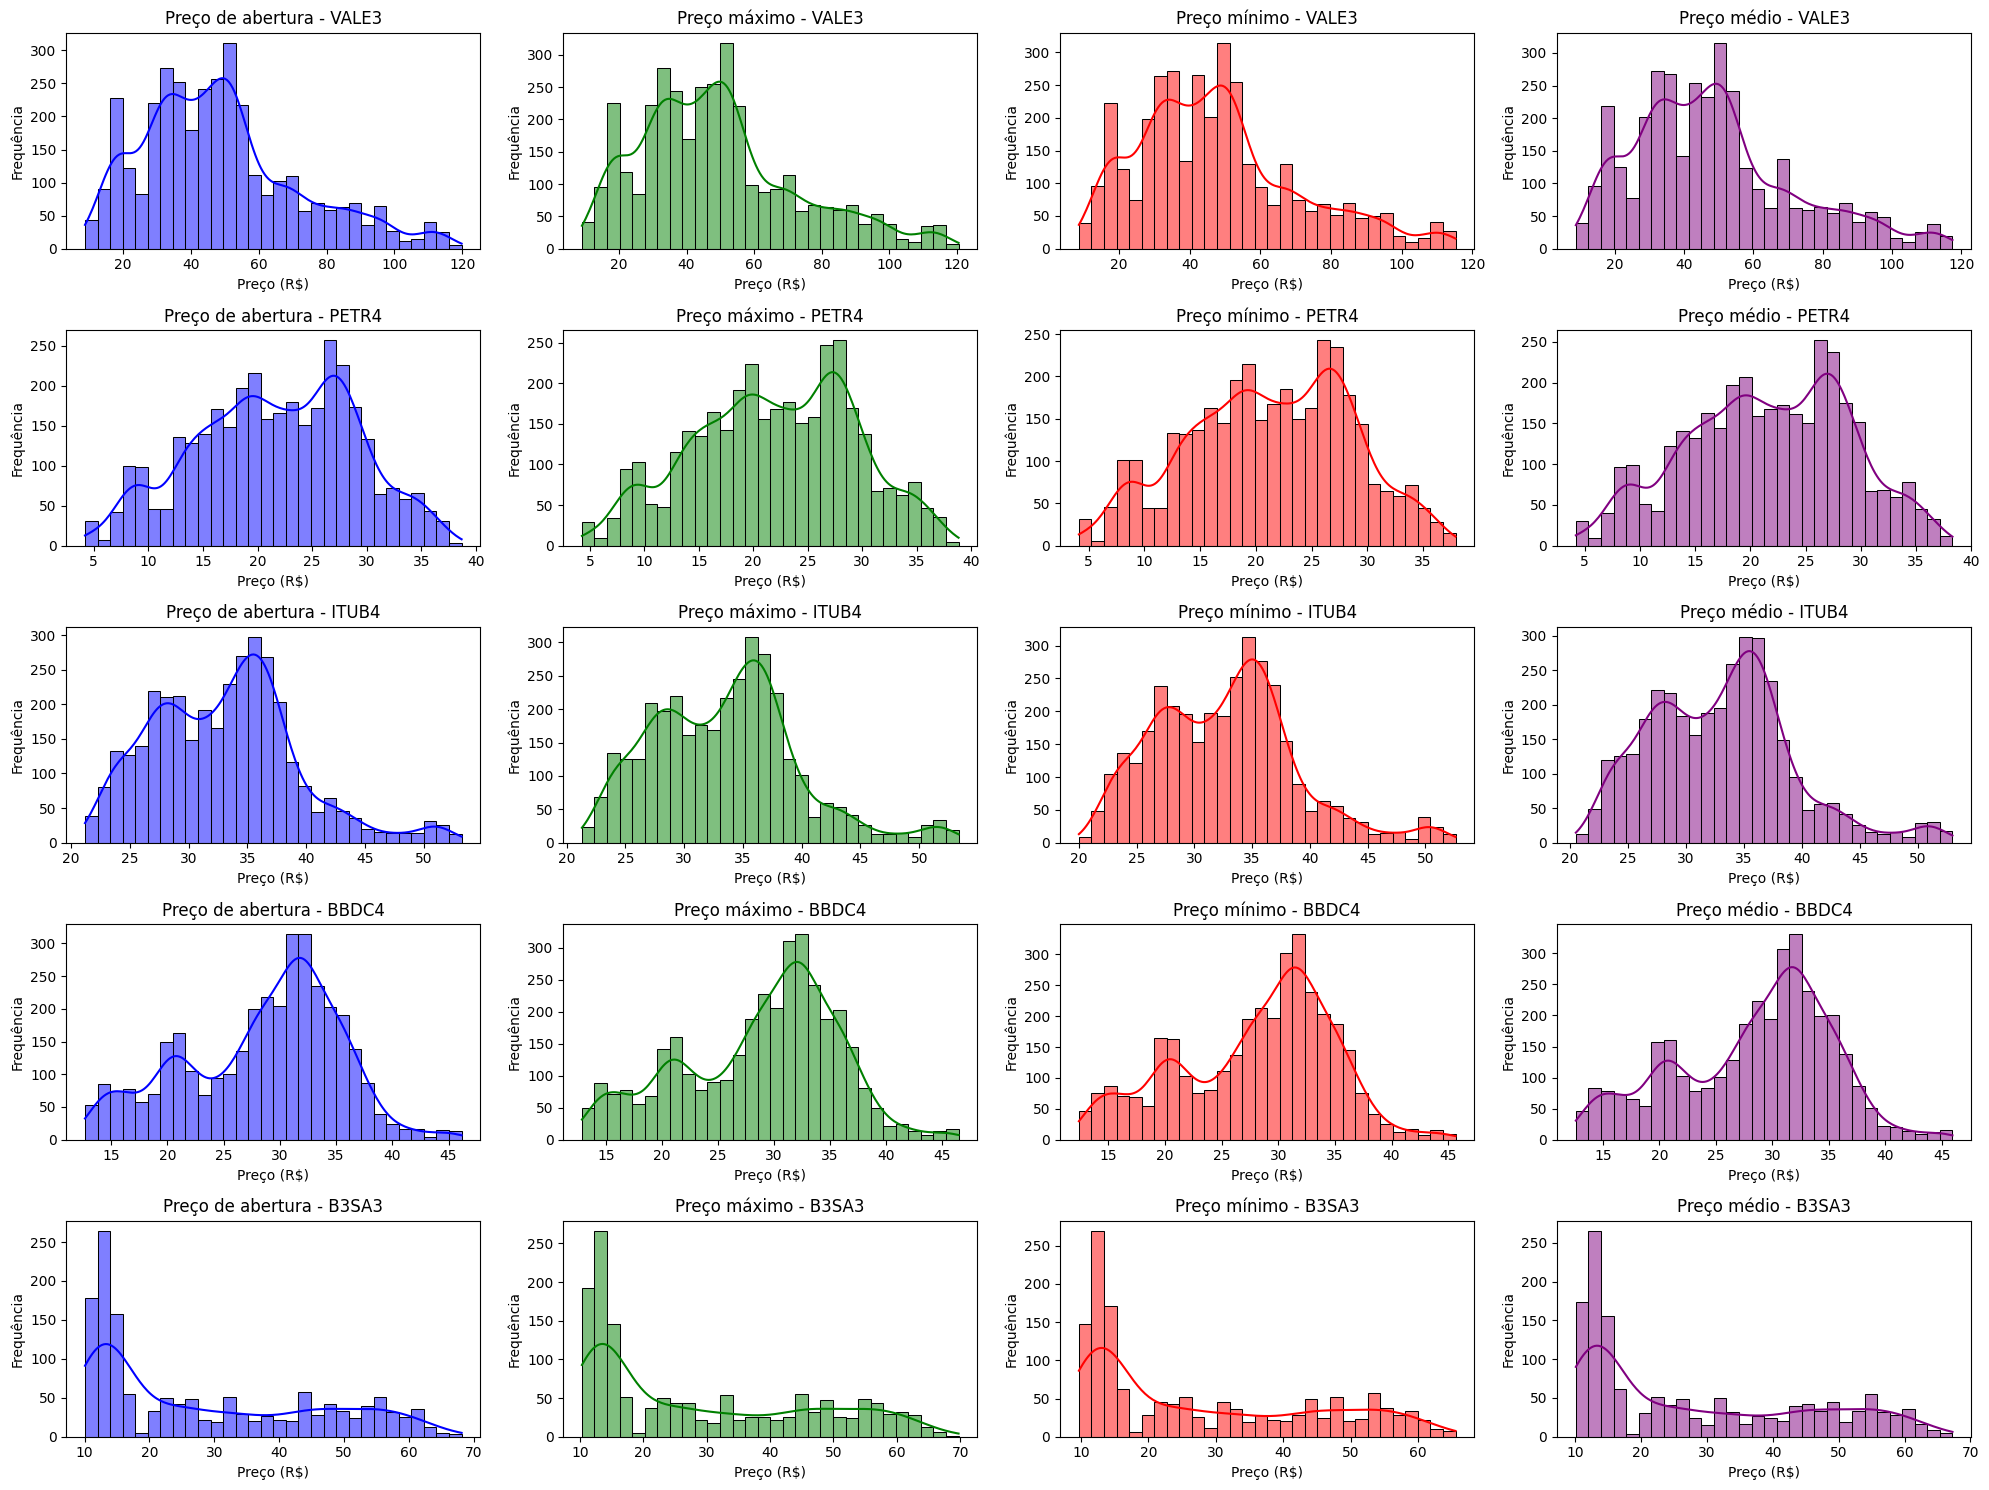

In [ ]:
# Configurando os gráficos para cada variável de preço para cada ação de interesse
fig, axes = plt.subplots(nrows=len(acoes_interesse), ncols=4, figsize=(20, 15))
axes = axes.flatten()  # Transforma o array de axes em 1D para facilitar o acesso

preco_vars = ['Preço de abertura', 'Preço máximo', 'Preço mínimo', 'Preço médio']
colors = ['blue', 'green', 'red', 'purple']

for i, codigo in enumerate(acoes_interesse):
    df_acao = df[df['Código de negociação'] == codigo]

    for j, var in enumerate(preco_vars):
        ax_index = i * 4 + j  # Calcula o índice do subplot atual
        sns.histplot(df_acao[var], bins=30, kde=True, color=colors[j], ax=axes[ax_index])
        axes[ax_index].set_title(f'{var} - {codigo}')
        axes[ax_index].set_xlabel('Preço (R$)')
        axes[ax_index].set_ylabel('Frequência')

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()

* **Preço de Abertura:** Os histogramas mostram como os preços de abertura das ações se distribuem ao longo do tempo. Podemos observar diferentes padrões de distribuição para cada ação, com algumas mostrando maior concentração em determinadas faixas de preço.
* **Preço Máximo e Mínimo:** Esses gráficos ajudam a visualizar a amplitude de variação diária dos preços. O preço máximo, por exemplo, mostra até onde os preços podem subir em um dia, enquanto o mínimo mostra o inverso. A largura das distribuições pode dar uma ideia sobre a volatilidade da ação.
* **Preço Médio:** Oferece uma visão da tendência central dos preços negociados ao longo do dia. A suavidade das curvas de densidade pode indicar a consistência dos preços ao longo do tempo.

**1. VALE3 (Vale)**

* **Generalidade:** A distribuição dos preços parece relativamente estável, com menos variação extrema em comparação com outras ações como PETR4.
* **Volatilidade:** Apresenta volatilidade moderada, com distribuições de preço máximo e mínimo indicando variações diárias razoáveis, mas sem extremos frequentes.
* **Investimento:** Pode ser considerada uma escolha sólida para investidores que buscam um equilíbrio entre risco e retorno, dada a sua estabilidade relativa e a importância da empresa no setor de mineração.

**2. PETR4 (Petrobras)**

* **Generalidade:** Mostra a maior amplitude nas distribuições de preço, especialmente nos preços máximo e mínimo, indicando dias de alta volatilidade.
* **Volatilidade:** Esta ação tem flutuações mais significativas, possivelmente devido a fatores externos como mudanças nos preços do petróleo e decisões políticas.
* **Investimento:** Adequada para investidores que toleram maior risco e buscam capitalizar sobre as variações significativas de preço.

**3. ITUB4 (Itaú Unibanco)**

* **Generalidade:** As distribuições são mais concentradas e apresentam menos caudas longas, sugerindo menor volatilidade.
* **Volatilidade:** Possui uma das menores volatilidades entre as ações analisadas, o que pode indicar maior estabilidade.
* **Investimento:** Ideal para investidores conservadores que preferem uma abordagem de menor risco e investimentos estáveis em bancos grandes.

**4. BBDC4 (Bradesco)**

* **Generalidade:** Similar ao ITUB4, com distribuições um pouco mais amplas, mas ainda indicando menor volatilidade que VALE3 e PETR4.
* **Volatilidade:** Volatilidade moderada, com padrões de preço indicando um risco menor do que empresas como a Petrobras.
* **Investimento:** Uma opção atraente para quem busca investimentos em instituições financeiras sólidas com menos exposição a oscilações abruptas.

**5. B3SA3 (B3 - Bolsa de Valores)**

* **Generalidade:** Tem distribuições de preços que indicam uma volatilidade mais alta, possivelmente devido ao seu papel central no mercado financeiro brasileiro.
* **Volatilidade:** Exibe uma variação mais significativa nos preços diários, que pode ser atribuída às dinâmicas do mercado de ações.
* **Investimento:** Pode ser interessante para investidores que buscam exposição ao setor financeiro e estão dispostos a aceitar maior volatilidade para potenciais retornos elevados.

**Correlação entre as variáveis**

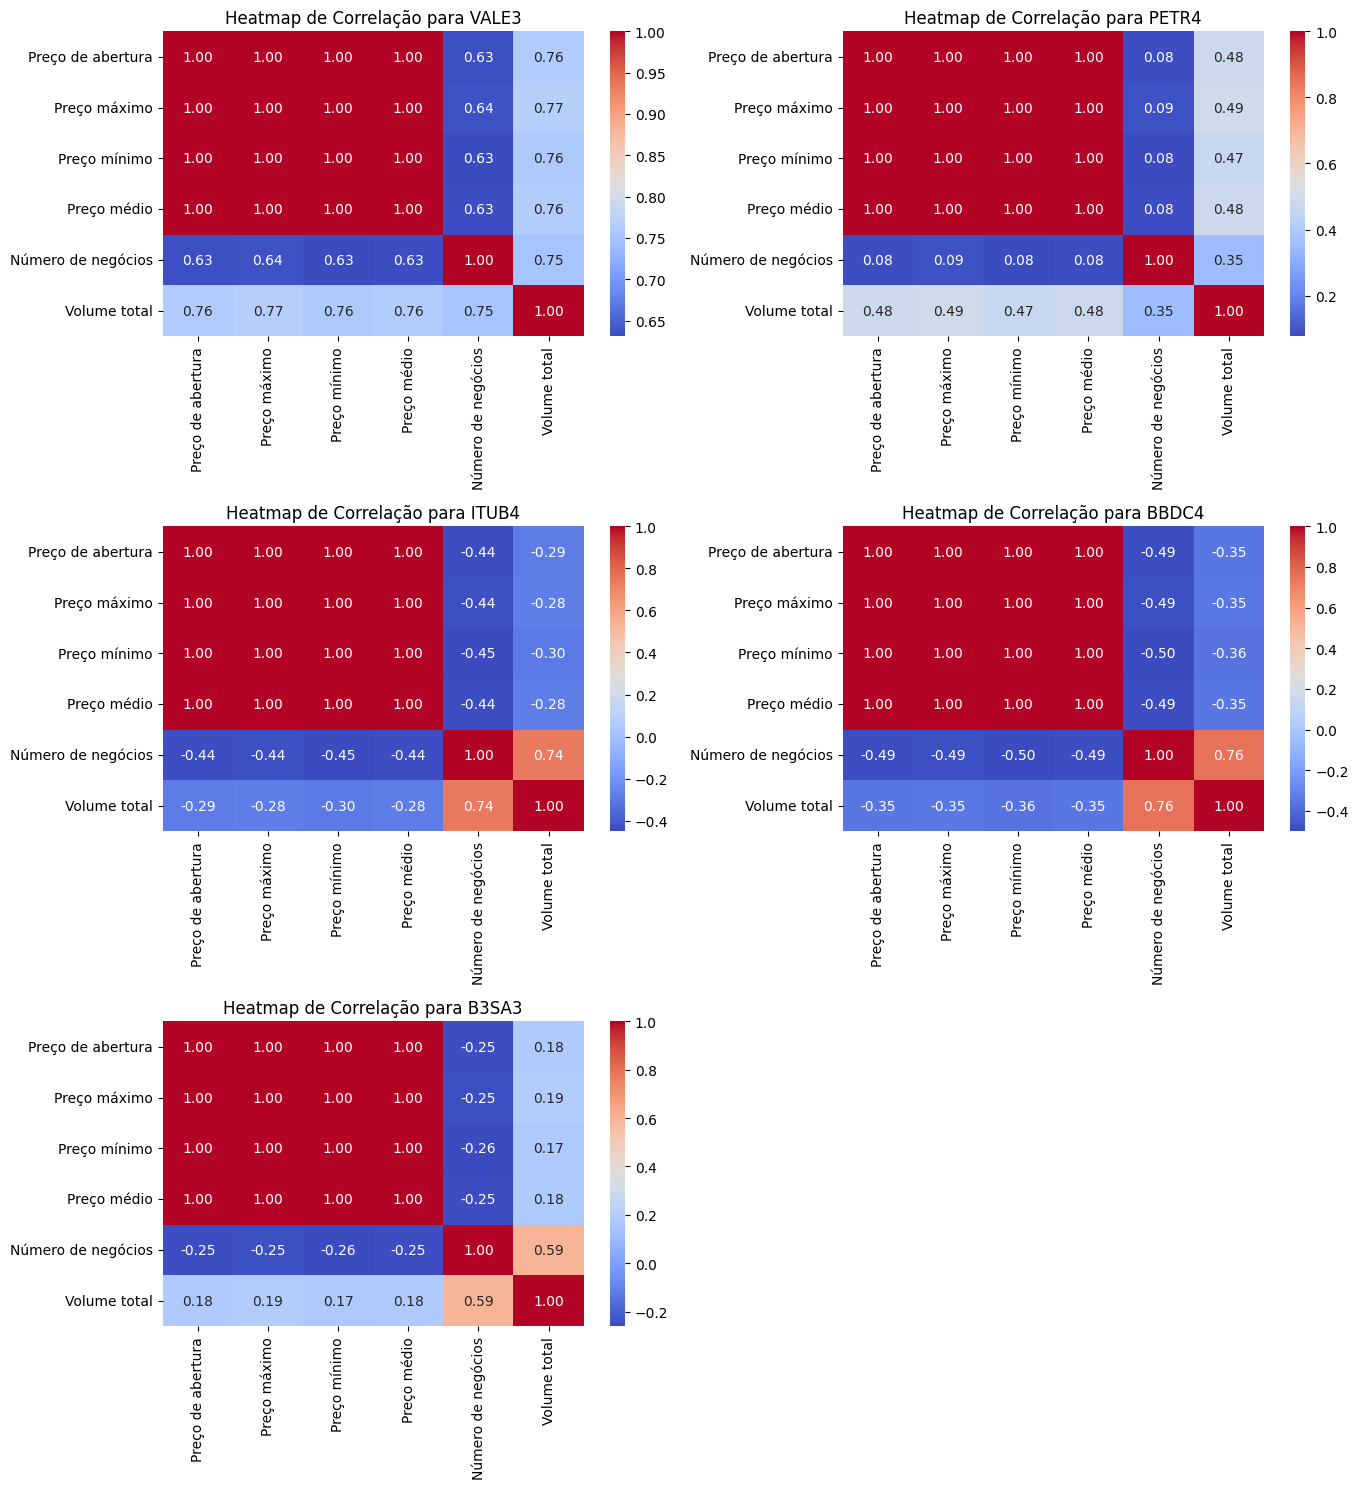

In [ ]:
# Configurando os gráficos de correlação para cada ação de interesse
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 15))
axes = axes.flatten()  # Transforma o array de axes em 1D para facilitar o acesso

correlated_vars = ['Preço de abertura', 'Preço máximo', 'Preço mínimo', 'Preço médio', 'Número de negócios', 'Volume total']

for i, codigo in enumerate(acoes_interesse):
    df_acao = df[df['Código de negociação'] == codigo]

    # Calcular a matriz de correlação
    corr_matrix = df_acao[correlated_vars].corr()

    # Plotar o heatmap
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, ax=axes[i])
    axes[i].set_title(f'Heatmap de Correlação para {codigo}')

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
if len(acoes_interesse) < len(axes):
    for ax in axes[len(acoes_interesse):]:  # Ocultar axes não utilizados
        ax.set_visible(False)
plt.show()

* **Correlações entre Preços:** Em todas as ações, há uma correlação forte e positiva entre os diferentes preços (abertura, máximo, mínimo, médio). Isso é esperado, pois movimentos de preço em uma direção durante o dia tendem a influenciar todos esses aspectos.
* **Correlação Preço e Volume/Número de Negócios:** Geralmente, há uma correlação positiva moderada entre o volume total e os preços, indicando que dias com preços mais altos tendem a ter maior volume de negociações. Similarmente, o número de negócios muitas vezes mostra correlação positiva, embora essa tendência possa ser menos pronunciada dependendo da ação.

**Gráfico de Dispersão**

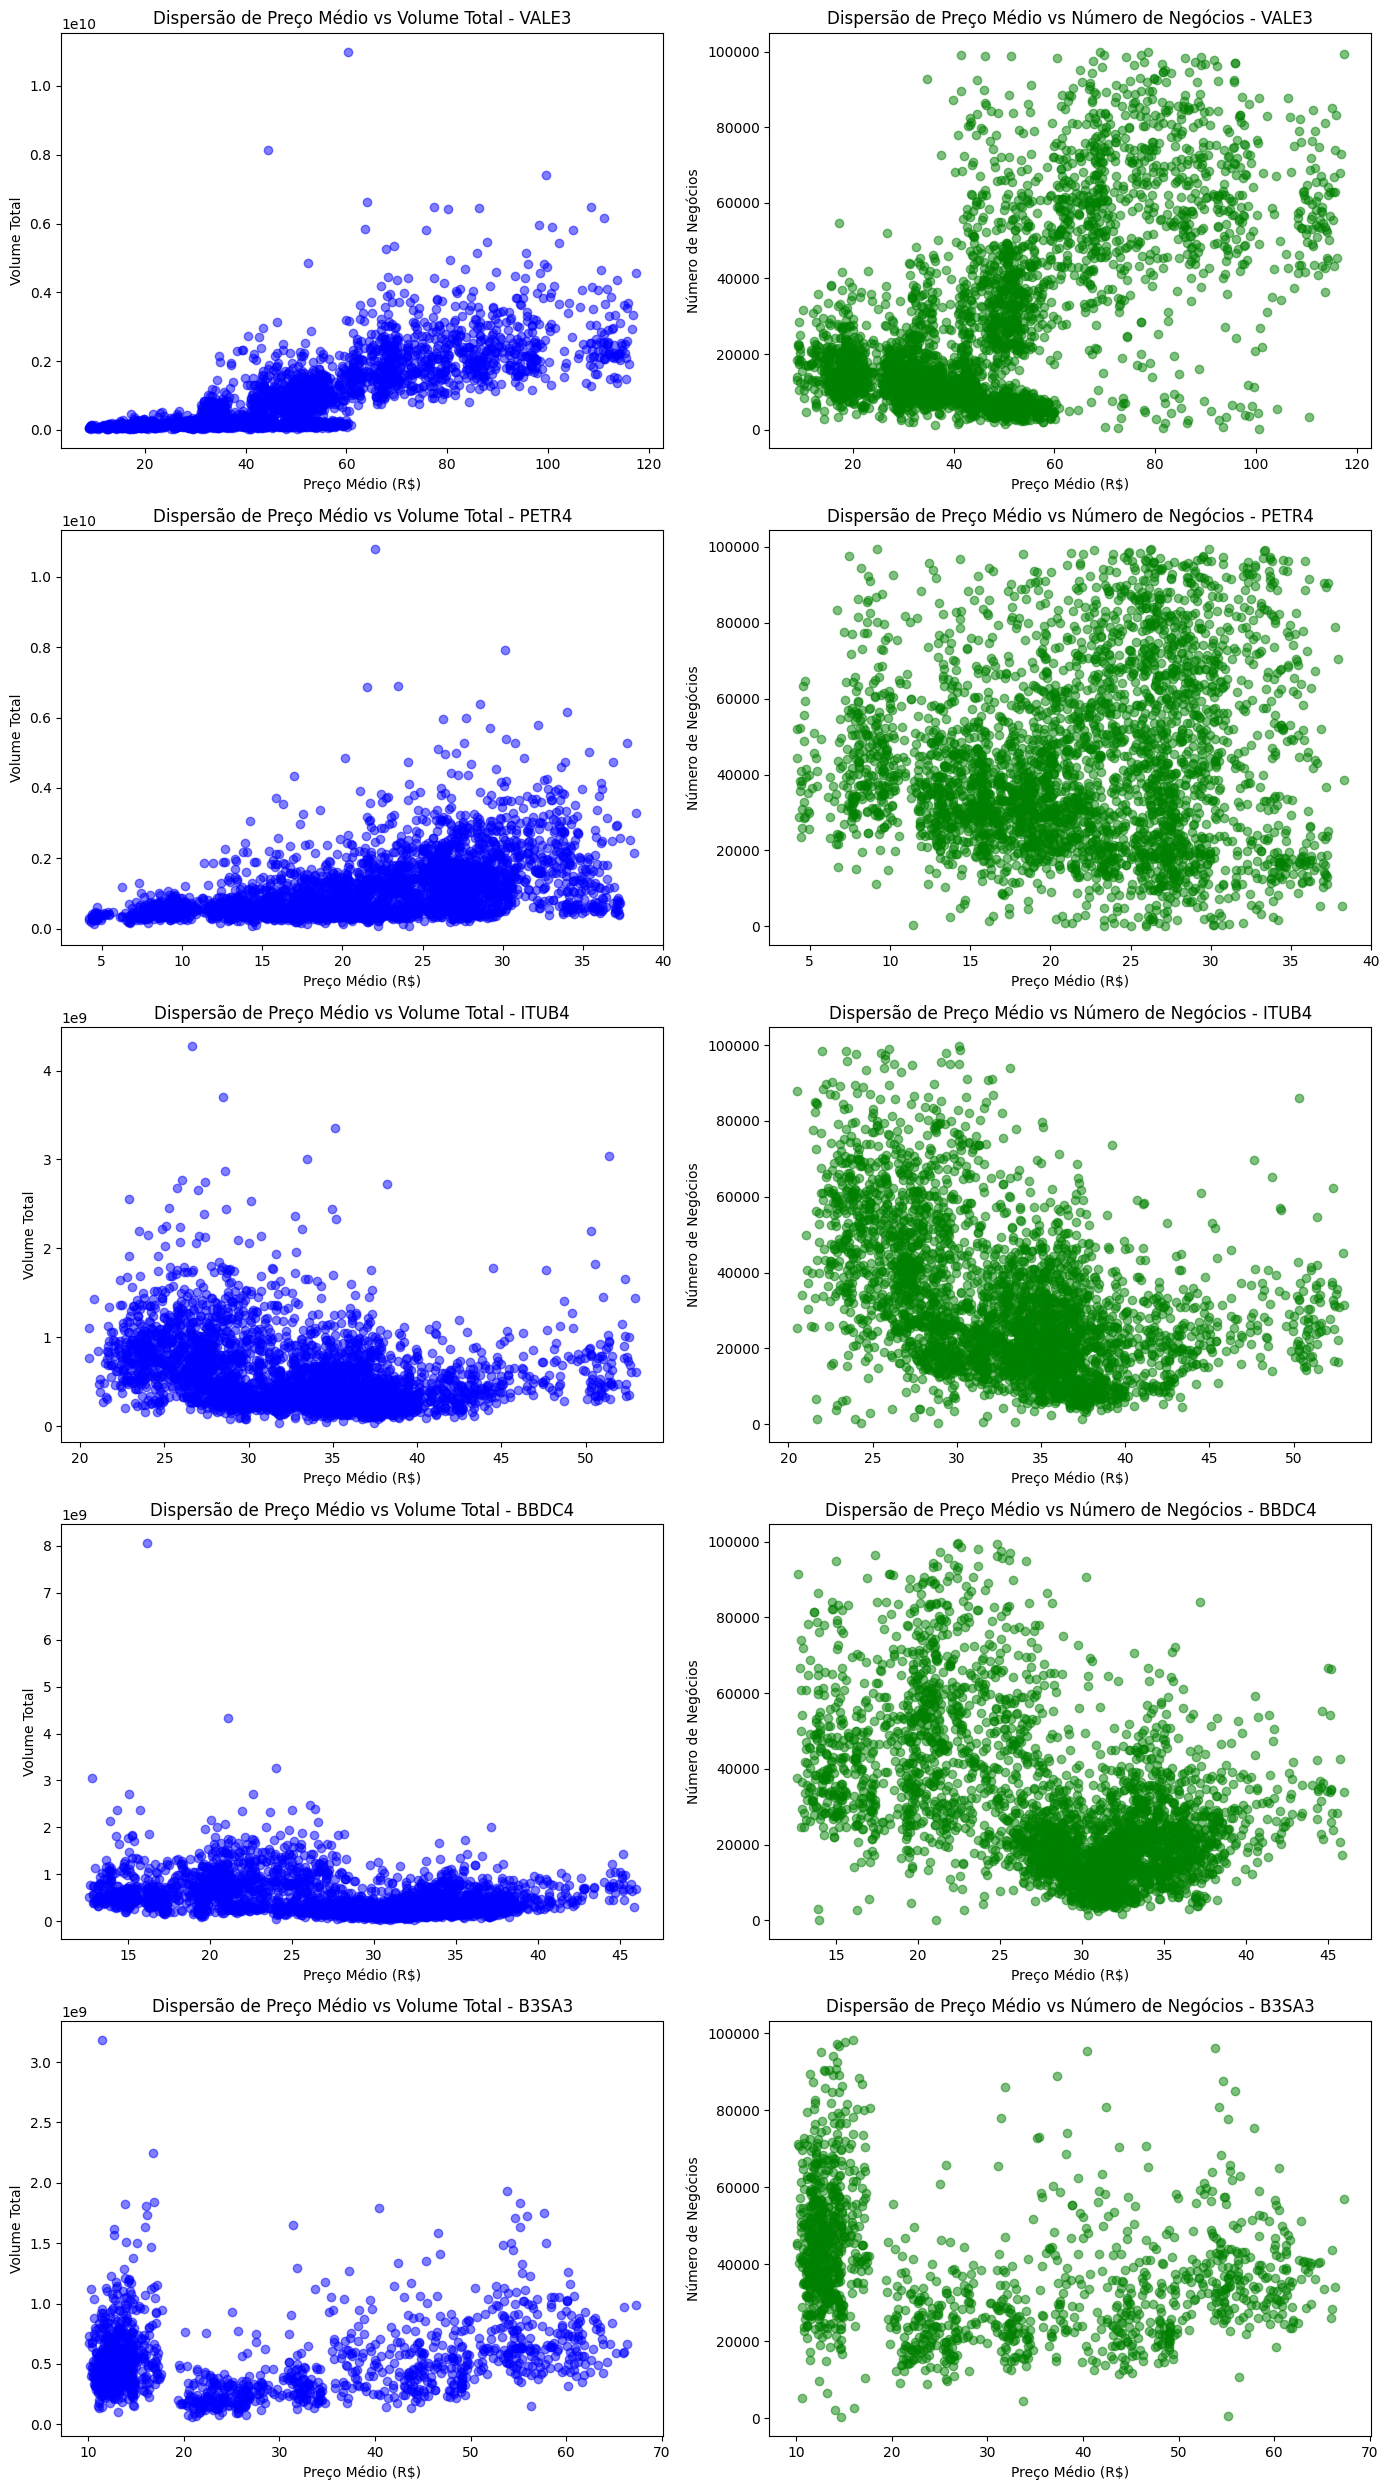

In [ ]:
# Criando gráficos de dispersão para cada ação de interesse
fig, axes = plt.subplots(nrows=len(acoes_interesse), ncols=2, figsize=(14, 5 * len(acoes_interesse)))

for i, codigo in enumerate(acoes_interesse):
    df_acao = df[df['Código de negociação'] == codigo]

    # Gráfico de dispersão para Preço Médio vs Volume Total
    axes[i, 0].scatter(df_acao['Preço médio'], df_acao['Volume total'], alpha=0.5, color='blue')
    axes[i, 0].set_title(f'Dispersão de Preço Médio vs Volume Total - {codigo}')
    axes[i, 0].set_xlabel('Preço Médio (R$)')
    axes[i, 0].set_ylabel('Volume Total')

    # Gráfico de dispersão para Preço Médio vs Número de Negócios
    axes[i, 1].scatter(df_acao['Preço médio'], df_acao['Número de negócios'], alpha=0.5, color='green')
    axes[i, 1].set_title(f'Dispersão de Preço Médio vs Número de Negócios - {codigo}')
    axes[i, 1].set_xlabel('Preço Médio (R$)')
    axes[i, 1].set_ylabel('Número de Negócios')

plt.tight_layout()
plt.show()

**VALE3:**

* **Preço Médio vs Volume Total:** Há uma correlação positiva, indicando que dias com preços médios mais altos tendem a ter um volume total maior.
* **Preço Médio vs Número de Negócios:** A correlação é também positiva, sugerindo que preços mais altos podem incentivar um maior número de transações.

**PETR4:**

* **Preço Médio vs Volume Total:** Apresenta uma das correlações mais fortes, refletindo a alta atividade de mercado em dias com preços médios elevados.
* **Preço Médio vs Número de Negócios:** Similarmente, há uma forte correlação positiva, mostrando uma alta atividade de negociação com o aumento dos preços.

**ITUB4:**

* **Preço Médio vs Volume Total:** A correlação é moderada, indicando uma relação positiva entre o preço médio e o volume, mas não tão forte quanto em PETR4 ou VALE3.
* **Preço Médio vs Número de Negócios:** Correlação positiva, indicando que preços mais altos tendem a atrair mais negócios, embora com menor intensidade comparada a PETR4.

**BBDC4:**

* **Preço Médio vs Volume Total:** Exibe uma correlação positiva, semelhante a ITUB4, mostrando que o volume de negociações aumenta com preços mais altos.
* **Preço Médio vs Número de Negócios:** Também demonstra uma correlação positiva, refletindo um aumento no número de negócios com o aumento do preço médio.

**B3SA3:**

* **Preço Médio vs Volume Total:** Esta ação, sendo da bolsa de valores, mostra uma correlação forte, possivelmente devido ao seu papel central no mercado financeiro.
* **Preço Médio vs Número de Negócios:** Correlação muito forte e clara, possivelmente a mais consistente entre todas, refletindo a sensibilidade dessa ação a variações de preço.

**Conclusões Gerais:**

* **Relações Positivas:** Todos os gráficos mostram uma tendência geral de correlação positiva entre o preço médio e as duas variáveis de mercado (volume total e número de negócios), indicando que preços mais altos geralmente correspondem a dias de maior atividade de mercado.
* **Implicações para Investidores:** Essas informações são cruciais para traders e investidores, pois indicam que preços elevados são muitas vezes acompanhados por uma maior liquidez, o que pode oferecer melhores oportunidades para entrada ou saída de posições.
* **Diferenças Setoriais:** Variações entre as ações refletem diferenças setoriais e características específicas de cada empresa, influenciando como cada ação responde às mudanças de mercado.

**Análise de Séries Temporais**

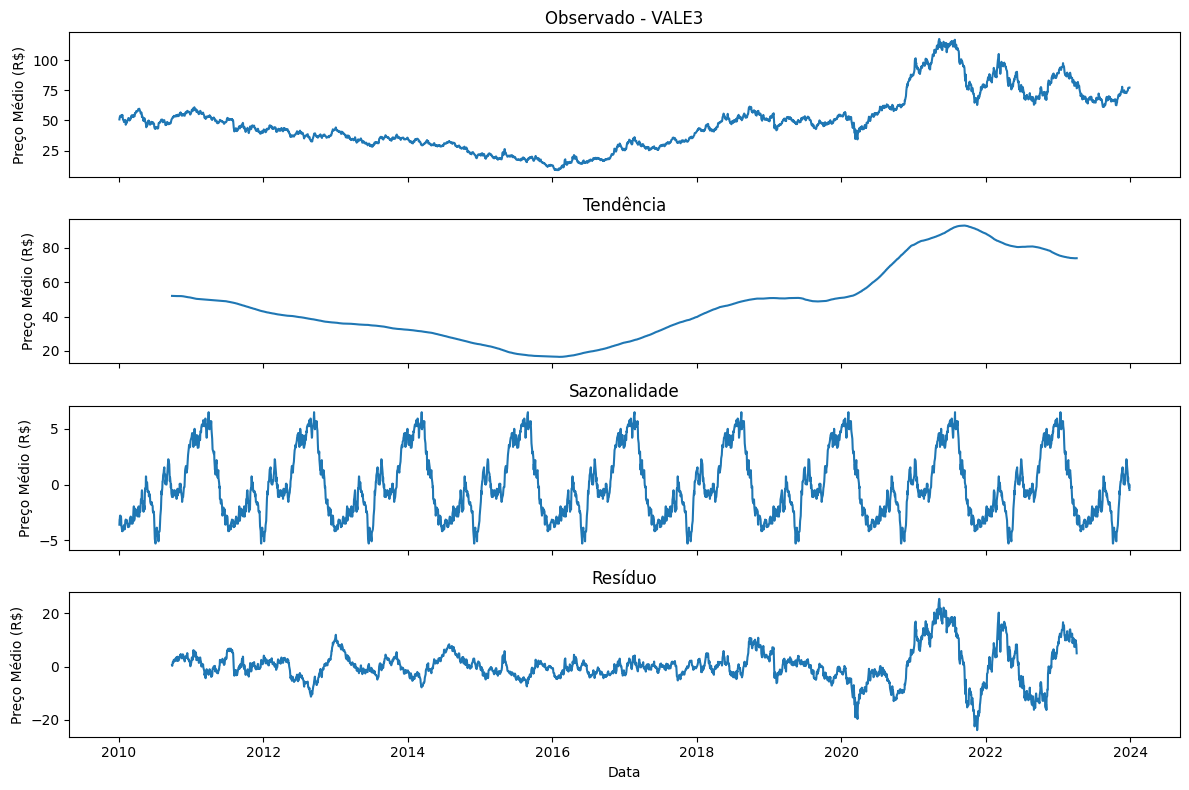

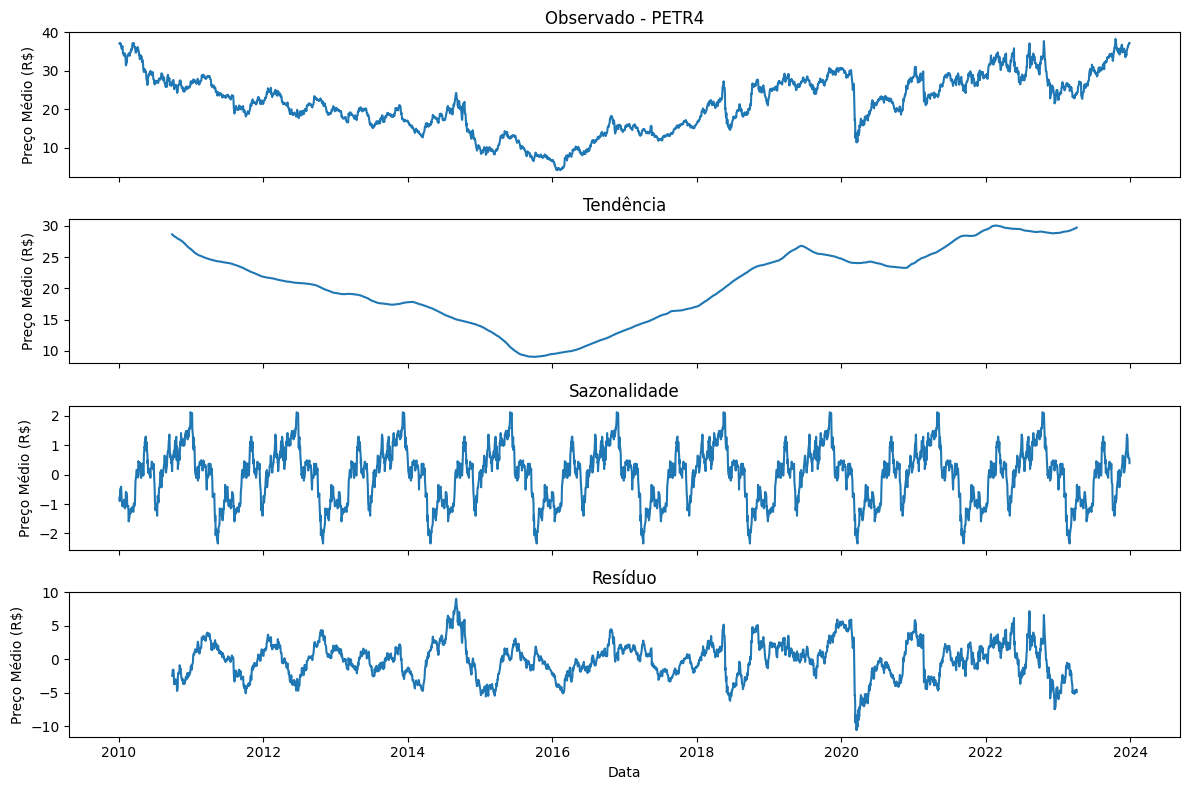

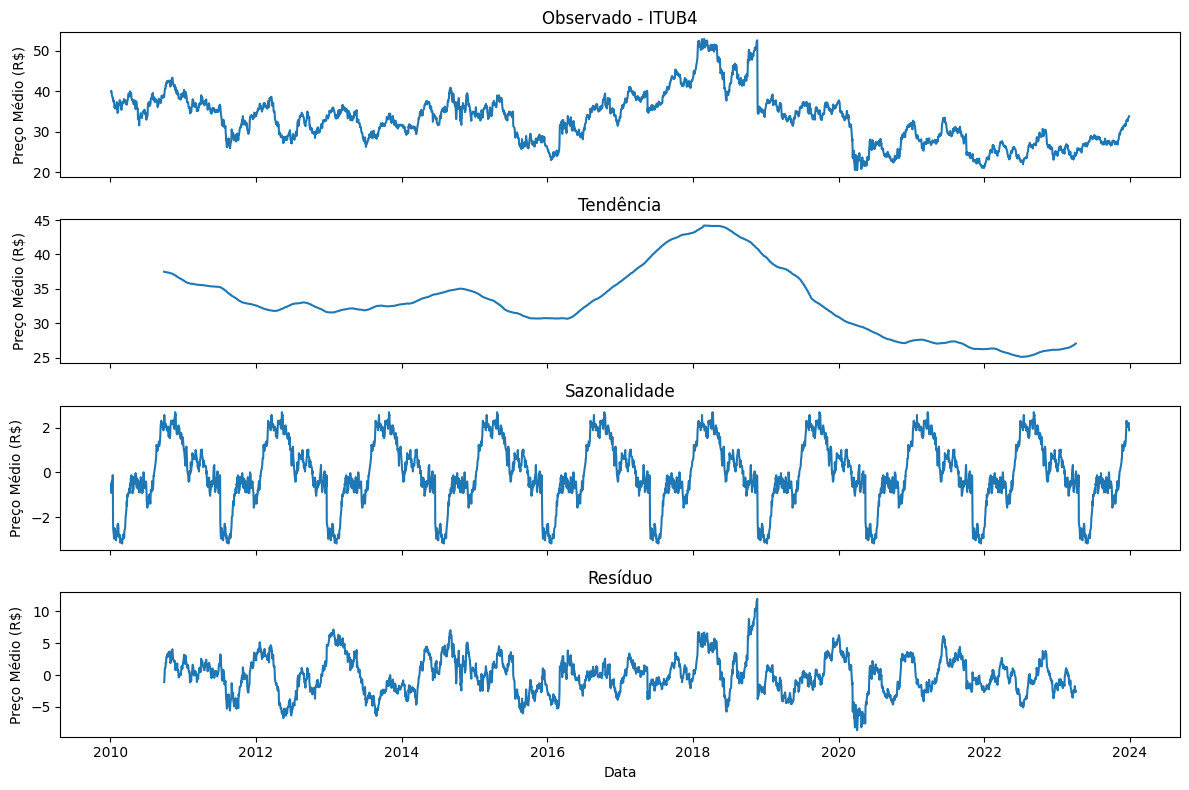

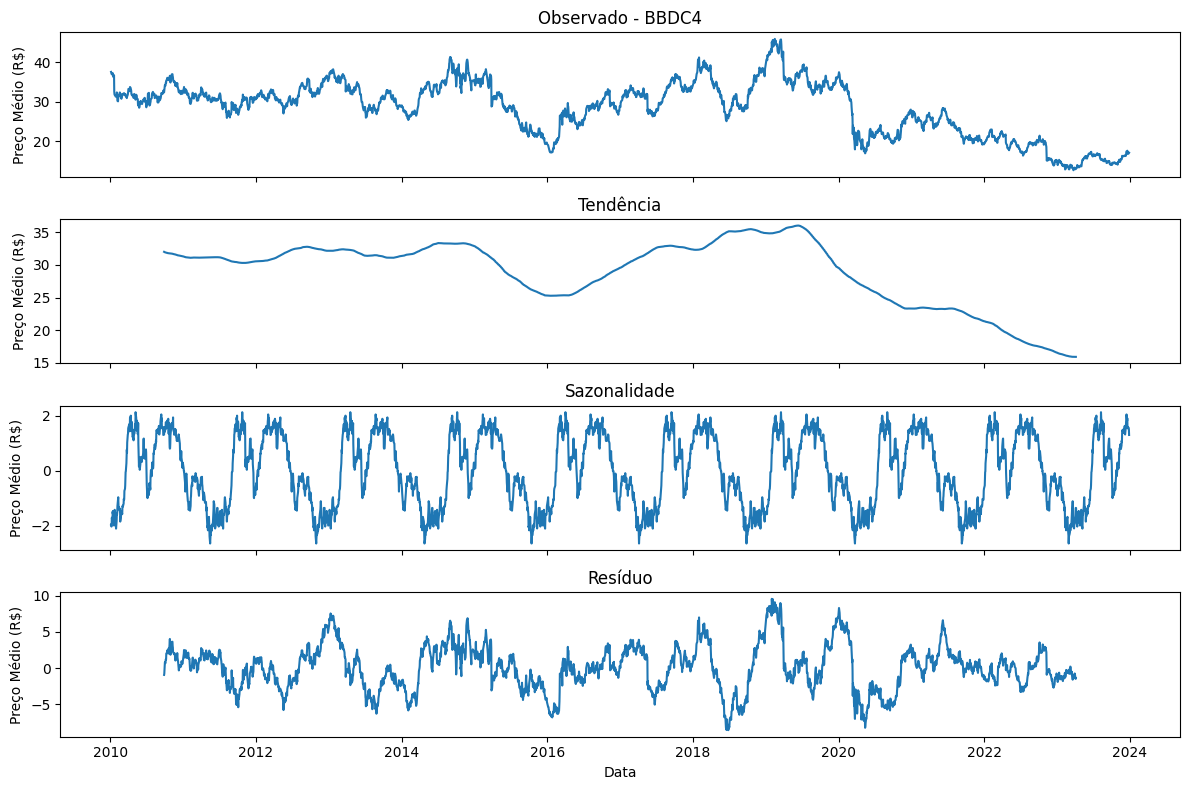

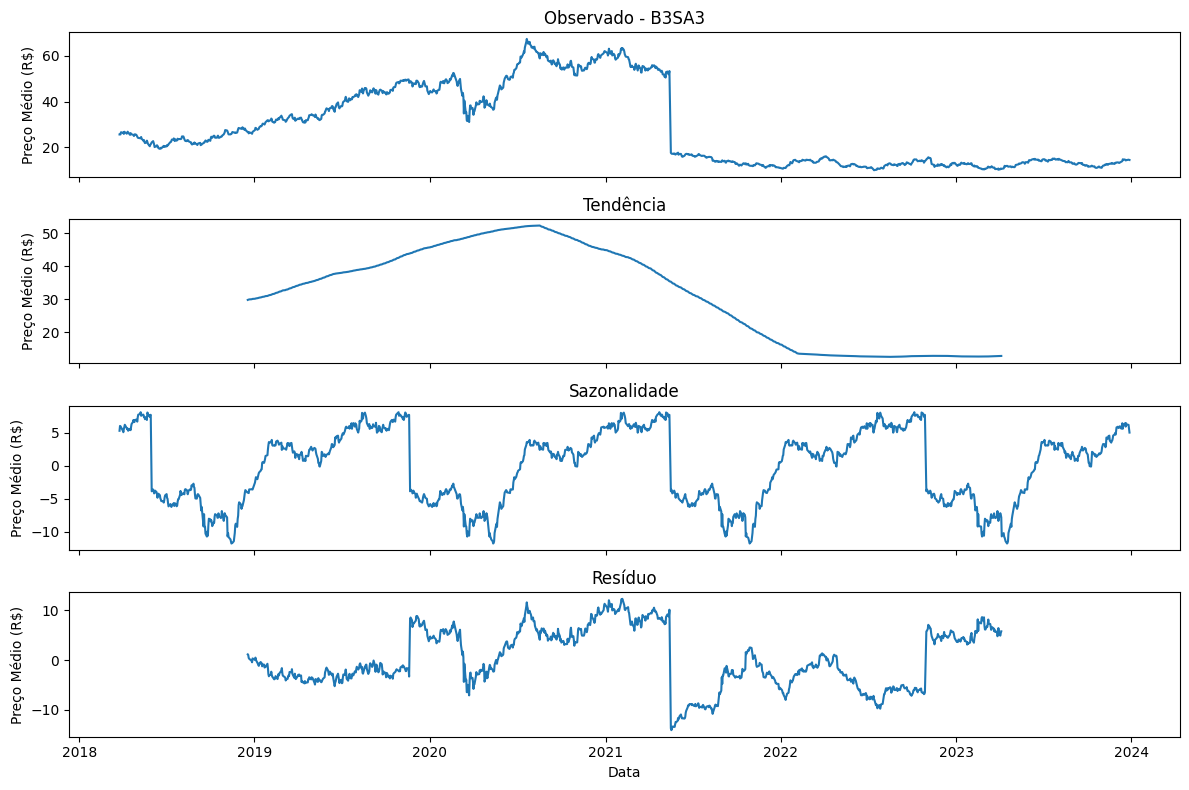

In [ ]:
for i, codigo in enumerate(acoes_interesse):
    # Selecionando dados da ação atual
    df_acao = df[df['Código de negociação'] == codigo].sort_values('Data do pregão')
    df_acao.set_index('Data do pregão', inplace=True)

    # Decomposição de séries temporais usando modelo aditivo
    result = sm.tsa.seasonal_decompose(df_acao['Preço médio'], model='additive', period=365)  # Ajuste 'period' conforme a sazonalidade esperada

    # Plotando a decomposição em figuras separadas
    fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    ax[0].plot(result.observed)
    ax[0].set_title(f'Observado - {codigo}')
    ax[0].set_ylabel('Preço Médio (R$)')

    ax[1].plot(result.trend)
    ax[1].set_title('Tendência')
    ax[1].set_ylabel('Preço Médio (R$)')

    ax[2].plot(result.seasonal)
    ax[2].set_title('Sazonalidade')
    ax[2].set_ylabel('Preço Médio (R$)')

    ax[3].plot(result.resid)
    ax[3].set_title('Resíduo')
    ax[3].set_ylabel('Preço Médio (R$)')
    ax[3].set_xlabel('Data')

    plt.tight_layout()
    plt.show()

**Análise das Decomposições de Séries Temporais:**

* **Observado:** Mostra os preços médios reais ao longo do tempo.
* **Tendência:** Indica a direção de longo prazo dos preços. Algumas ações mostram uma tendência clara de aumento ou diminuição ao longo dos anos, enquanto outras são mais estáveis.
* **Sazonalidade:** Revela padrões cíclicos dentro de um ano. Esta análise é particularmente útil para identificar comportamentos específicos que se repetem sazonalmente.
* **Resíduo:** Inclui o que resta da série temporal após a remoção da tendência e sazonalidade. É uma boa indicação de volatilidade não explicada pelos modelos simples de tendência e sazonalidade.

**Conclusões:**

* **VALE3 e PETR4:** Ambas mostram uma forte tendência e sazonalidade, indicativas de fatores de mercado que afetam seus preços ao longo do tempo. A volatilidade não explicada nos resíduos pode ser devido a eventos específicos do mercado ou notícias.
* **ITUB4 e BBDC4:** Apresentam tendências menos pronunciadas, sugerindo uma maior estabilidade. Sazonalidades são visíveis, possivelmente refletindo ciclos econômicos que influenciam o setor bancário.
* **B3SA3:** Como uma ação da bolsa de valores, mostra tendências e sazonalidades que podem ser diretamente influenciadas pelas condições do mercado financeiro.

**Teste de Normalidade:** Para verificar se os preços das ações seguem uma distribuição normal, o que é útil para muitos modelos financeiros.

In [ ]:
# Inicializar o dicionário para armazenar os resultados dos testes de normalidade
normality_tests = {}

for codigo in acoes_interesse:
    # Selecionando os preços médios da ação atual
    df_acao = df[df['Código de negociação'] == codigo]
    prices = df_acao['Preço médio']

    # Realizando o teste de Shapiro-Wilk
    shapiro_test = shapiro(prices)
    normality_tests[codigo] = {
        'Statistic': shapiro_test.statistic,
        'p-value': shapiro_test.pvalue  # Corrigido para usar .pvalue
    }

normality_tests

{'VALE3': {'Statistic': 0.9515983462333679, 'p-value': 2.104487977087523e-32},
 'PETR4': {'Statistic': 0.9873039126396179, 'p-value': 4.272478853703769e-17},
 'ITUB4': {'Statistic': 0.971157431602478, 'p-value': 7.23119579310705e-26},
 'BBDC4': {'Statistic': 0.9668059349060059, 'p-value': 1.4515473990304104e-27},
 'B3SA3': {'Statistic': 0.8538538217544556, 'p-value': 1.9008368134170263e-34}}

**Análise dos Resultados:**

Os p-values extremamente baixos para todas as ações indicam que podemos rejeitar a hipótese nula de que os dados seguem uma distribuição normal. Isso significa que a distribuição dos preços médios para cada uma dessas ações não é normal.

**Implicações**

* **Modelagem Estatística:** A não-normalidade dos preços sugere que modelos que assumem normalidade (como muitos modelos de finanças clássicas) podem não ser apropriados sem transformações dos dados.
* **Estratégias de Investimento:** Investidores podem precisar considerar estratégias que não dependam da normalidade dos retornos.
* **Risco Financeiro:** A análise de risco e a precificação de derivativos podem precisar de métodos que levem em conta as distribuições reais dos preços.



**Teste de Hipóteses:** Suponhamos que um evento importante ocorreu em 01 de junho de 2026. Vamos analisar 30 dias antes e depois desse evento para ver se há uma diferença significativa nos preços das ações.

In [ ]:
# Definindo a data do evento em 2021
evento_data_2021 = pd.to_datetime("2021-06-01")

# Resultados do teste t para cada ação com a nova data
t_test_results_2021 = {}

for codigo in acoes_interesse:
    df_acao = df[df['Código de negociação'] == codigo]
    df_acao['Data do pregão'] = pd.to_datetime(df_acao['Data do pregão'], format='%Y%m%d')

    # Filtrando 30 dias antes e depois do evento
    pre_event_2021 = df_acao[(df_acao['Data do pregão'] < evento_data_2021) & (df_acao['Data do pregão'] >= evento_data_2021 - pd.Timedelta(days=30))]
    post_event_2021 = df_acao[(df_acao['Data do pregão'] > evento_data_2021) & (df_acao['Data do pregão'] <= evento_data_2021 + pd.Timedelta(days=30))]

    # Realizando o teste t
    t_stat_2021, p_value_2021 = ttest_ind(pre_event_2021['Preço médio'], post_event_2021['Preço médio'], equal_var=False)  # Usando Welch's t-test
    t_test_results_2021[codigo] = {'t-statistic': t_stat_2021, 'p-value': p_value_2021}

t_test_results_2021

<ipython-input-35-2cf856ee5a48>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acao['Data do pregão'] = pd.to_datetime(df_acao['Data do pregão'], format='%Y%m%d')
<ipython-input-35-2cf856ee5a48>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acao['Data do pregão'] = pd.to_datetime(df_acao['Data do pregão'], format='%Y%m%d')
<ipython-input-35-2cf856ee5a48>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

{'VALE3': {'t-statistic': 0.5737241542178989, 'p-value': 0.569658122981894},
 'PETR4': {'t-statistic': -12.685703531101598,
  'p-value': 1.680992313022527e-12},
 'ITUB4': {'t-statistic': -10.9525724279489, 'p-value': 4.813982387722129e-13},
 'BBDC4': {'t-statistic': -8.335733954084498,
  'p-value': 2.7944164761849654e-10},
 'B3SA3': {'t-statistic': 4.394789099143475,
  'p-value': 0.00027902242282168085}}

**PETR4, ITUB4, e BBDC4:** Impacto Negativo Significativo do Evento:

* **PETR4:** O teste t resultou em um t-statistic de -12.69 e um p-value de
$1.68 \times 10^{-12}$
 .
* **ITUB4:** O teste t resultou em um t-statistic de -10.95 e um p-value de
$4.81 \times 10^{-13}$
 .
* **BBDC4:** O teste t resultou em um t-statistic de -8.34 e um p-value de
$2.79 \times 10^{-10}$

**Justificativa:**

Estes p-values extremamente baixos sugerem uma rejeição muito forte da hipótese nula de que não há diferença nos preços médios antes e depois do evento. Os t-statistics negativos indicam que os preços médios após o evento foram significativamente menores do que antes. Isso aponta para uma resposta do mercado negativamente significativa ao evento, o que implica que o evento teve um efeito depreciativo nos preços dessas ações.

**VALE3:** Nenhuma Mudança Significativa Associada ao Evento:

* **VALE3:** O teste t resultou em um t-statistic de 0.574 e um p-value de 0.570.

**Justificativa:**

O p-value acima do limiar usual de 0.05 indica que não podemos rejeitar a hipótese nula de que não há diferença nos preços médios antes e depois do evento. Isso significa que o evento não teve um impacto estatisticamente significativo nos preços da VALE3. A ausência de uma resposta significativa pode ser atribuída à resiliência do setor de mineração ou a outros fatores macroeconômicos ou corporativos que influenciam mais fortemente o preço desta ação do que o evento específico em questão.

**B3SA3:** Impacto Positivo Significativo do Evento

* **B3SA3:** O teste t resultou em um t-statistic de 4.39 e um p-value de 0.00028.

**Justificativa:**

O p-value muito abaixo de 0.05 permite rejeitar a hipótese nula de que não há diferença nos preços médios antes e depois do evento, enquanto o t-statistic positivo indica que os preços médios após o evento foram significativamente maiores. Isso sugere que o evento foi percebido positivamente pelo mercado, resultando em uma valorização dos preços das ações da B3SA3. Esse impacto positivo pode estar relacionado a fatores específicos da indústria financeira ou a mudanças nas operações ou regulamentações que beneficiaram a empresa.

**Conclusão Geral**

Esses testes oferecem uma compreensão profunda de como diferentes eventos podem impactar variadamente setores e empresas individuais no mercado de ações, permitindo aos investidores e analistas fazerem avaliações informadas e estratégicas baseadas em evidências estatísticas.








In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15295 entries, 0 to 15294
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Data do pregão                    15295 non-null  datetime64[ns]
 1   Código de negociação              15295 non-null  object        
 2   Preço de abertura                 15295 non-null  float64       
 3   Preço máximo                      15295 non-null  float64       
 4   Preço mínimo                      15295 non-null  float64       
 5   Preço médio                       15295 non-null  float64       
 6   Preço do último negócio           15295 non-null  float64       
 7   Preço da melhor oferta de compra  15295 non-null  float64       
 8   Preço da melhor oferta de venda   15295 non-null  float64       
 9   Número de negócios                15295 non-null  int64         
 10  Quantidade total de títulos       15295 non-nu

###**4. Modelagem**

* **Seleção de Modelos:** Análise e seleção entre modelos LSTM e/ou RNN, baseando-se em estudos de caso e benchmarks.

* **Construção e Treinamento:** Implementação dos modelos utilizando frameworks como TensorFlow ou PyTorch, com ajustes iterativos para melhorar o desempenho.

* **Validação:** Utilização de técnicas de validação cruzada e ajuste de hiperparâmetros para garantir a generalização do modelo.

**Modelo LSTM (Long Short-Term Memory)**

A decisão de escolher uma combinação de camadas de Conv1D, MultiHeadAttention e LSTM é baseada na natureza dos dados e nos requisitos do problema. LSTM é uma escolha comum para lidar com séries temporais devido à sua capacidade de capturar dependências de longo prazo, enquanto as camadas de convolução (Conv1D) podem ajudar a extrair padrões locais nos dados. A adição de camadas de MultiHeadAttention pode melhorar ainda mais a capacidade do modelo de capturar relações temporais complexas.

**Framework de Desenvolvimento**

A escolha do TensorFlow como framework de desenvolvimento oferece diversas vantagens, incluindo uma vasta comunidade de suporte, documentação abrangente e uma ampla gama de ferramentas integradas para desenvolvimento e treinamento de modelos de aprendizado profundo. Além disso, TensorFlow é conhecido por sua eficiência e escalabilidade, sendo adequado para lidar com conjuntos de dados grandes e complexos.

**Normalização de Dados**

In [ ]:
directory_path_encoder = "/content/drive/MyDrive/Colab Notebooks/Encoders_Modelo"

# Normalização da coluna 'Preço do último negócio' para um intervalo de 0 a 1
scaler_price = MinMaxScaler(feature_range=(0, 1))
df['Preço do último negócio normalizado'] = scaler_price.fit_transform(df[['Preço do último negócio']])
joblib.dump(scaler_price, 'scaler_price.pkl')
joblib.dump(scaler_price, os.path.join(directory_path_encoder, 'scaler_price.pkl'))

# Conversão da coluna 'Data do pregão' para timestamp e normalização
df['Data do pregão'] = pd.to_datetime(df['Data do pregão'])
df['Data do pregão'] = df['Data do pregão'].map(pd.Timestamp.timestamp)
scaler_timestamp = MinMaxScaler(feature_range=(0, 1))
df['Data do pregão normalizado'] = scaler_timestamp.fit_transform(df[['Data do pregão']])
joblib.dump(scaler_timestamp, 'scaler_timestamp.pkl')
joblib.dump(scaler_timestamp, os.path.join(directory_path_encoder, 'scaler_timestamp.pkl'))

['/content/drive/MyDrive/Colab Notebooks/Encoders_Modelo/scaler_timestamp.pkl']

**Codificação One-Hot**

In [ ]:
# Aplicação de one-hot encoding na coluna 'Código de negociação'
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df[['Código de negociação']]).toarray()
encoded_feature_names = encoder.get_feature_names_out(['Código de negociação'])
df_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)
df_final = pd.concat([df, df_encoded], axis=1)
joblib.dump(encoder, 'encoder.pkl')
joblib.dump(encoder, os.path.join(directory_path_encoder, 'encoder.pkl'))

['/content/drive/MyDrive/Colab Notebooks/Encoders_Modelo/encoder.pkl']

**Preparação das Sequências**

In [ ]:
# Preparação das sequências para o treinamento do modelo
feature_columns = ['Preço do último negócio normalizado', 'Data do pregão normalizado'] + list(encoded_feature_names)
data = df_final[feature_columns].values
target = df_final['Preço do último negócio normalizado'].values

def create_sequences(data, target, window_size=60):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(data, target)


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15295 entries, 0 to 15294
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Data do pregão                       15295 non-null  float64
 1   Código de negociação                 15295 non-null  object 
 2   Preço de abertura                    15295 non-null  float64
 3   Preço máximo                         15295 non-null  float64
 4   Preço mínimo                         15295 non-null  float64
 5   Preço médio                          15295 non-null  float64
 6   Preço do último negócio              15295 non-null  float64
 7   Preço da melhor oferta de compra     15295 non-null  float64
 8   Preço da melhor oferta de venda      15295 non-null  float64
 9   Número de negócios                   15295 non-null  int64  
 10  Quantidade total de títulos          15295 non-null  int64  
 11  Volume total                

**Treinamento do Modelo**

A divisão dos dados em conjuntos de treinamento, validação e teste é essencial para avaliar adequadamente o desempenho do modelo e garantir sua capacidade de generalização para dados não vistos. O uso de validação cruzada (K-Fold) aumenta a robustez da avaliação do modelo, permitindo a otimização dos hiperparâmetros de forma mais confiável e reduzindo o viés na seleção do conjunto de validação.


**Avaliação do Modelo**

O critério de parada antecipada (early stopping) durante o treinamento ajuda a evitar o sobreajuste (overfitting), garantindo que o modelo generalize bem para novos dados. As métricas de desempenho, como erro médio quadrático (MSE), erro médio absoluto (MAE) e coeficiente de determinação (R²), fornecem insights sobre a precisão e a capacidade preditiva do modelo em diferentes contextos e cenários.

**Treinamento do Modelo com Transformer e LSTM**

In [ ]:
# Configuração e treinamento de um modelo combinando camadas de Conv1D, MultiHeadAttention e LSTM
inputs = Input(shape=(X.shape[1], X.shape[2]))
x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = MultiHeadAttention(num_heads=2, key_dim=64)(x, x, x)
x = LayerNormalization()(x)
x = LSTM(100, return_sequences=True)(x)
x = Dropout(0.4)(x)
x = LSTM(100)(x)
x = Dropout(0.4)(x)
x = Dense(100, activation='relu')(x)
outputs = Dense(1)(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=RMSprop(lr=0.0001), loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Validação cruzada K-Fold para avaliar o modelo
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train, epochs=150, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])
    evaluation = model.evaluate(X_test, y_test)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    fold_results.append((evaluation, mse, mae, r2))

Epoch 1/150
191/191 [==============================] - 35s 159ms/step - loss: 0.0284 - val_loss: 0.0237
Epoch 2/150
191/191 [==============================] - 30s 159ms/step - loss: 0.0186 - val_loss: 0.0221
Epoch 3/150
191/191 [==============================] - 29s 154ms/step - loss: 0.0173 - val_loss: 0.0181
Epoch 4/150
191/191 [==============================] - 29s 154ms/step - loss: 0.0166 - val_loss: 0.0176
Epoch 5/150
191/191 [==============================] - 34s 180ms/step - loss: 0.0163 - val_loss: 0.0155
Epoch 6/150
191/191 [==============================] - 32s 170ms/step - loss: 0.0161 - val_loss: 0.0154
Epoch 7/150
191/191 [==============================] - 29s 155ms/step - loss: 0.0155 - val_loss: 0.0151
Epoch 8/150
191/191 [==============================] - 31s 162ms/step - loss: 0.0154 - val_loss: 0.0148
Epoch 9/150
191/191 [==============================] - 33s 175ms/step - loss: 0.0151 - val_loss: 0.0169
Epoch 10/150
191/191 [==============================] - 31s 160m

**Salvamento do Modelo**

O salvamento do modelo após o treinamento é crucial para garantir sua reutilização e implantação em ambientes de produção. Isso permite que o modelo seja facilmente carregado e utilizado para fazer previsões em novos dados sem a necessidade de re-treinamento, economizando tempo e recursos computacionais.

**Avaliação e Salvamento do Modelo**

In [ ]:
# Salvar o modelo
model.save('lstm_cnn_attention_model.keras')
model_path = os.path.join(directory_path_encoder, 'lstm_cnn_attention_model.keras')
model.save(model_path)

In [ ]:
# Avaliação adicional do modelo
test_index = kf.split(X).__next__()[1]
X_test = X[test_index]
y_test = y[test_index]
predictions = model.predict(X_test)

96/96 [==============================] - 3s 27ms/step


**Métricas do Modelo**

In [ ]:
  # RMSE - Root Mean Squared Error
  rmse = np.sqrt(mean_squared_error(y_test, predictions))
  print(f'Root Mean Squared Error (RMSE): {rmse}')

  # MAPE - Mean Absolute Percentage Error
  mape = mean_absolute_percentage_error(y_test, predictions)
  print(f'Mean Absolute Percentage Error (MAPE): {mape}')

  # Median Absolute Error
  median_ae = median_absolute_error(y_test, predictions)
  print(f'Median Absolute Error: {median_ae}')

  # MSLE - Mean Squared Logarithmic Error
  # Certifique-se de que não há valores negativos em y_test e predictions para calcular MSLE
  if np.all((y_test >= 0) & (predictions >= 0)):
      msle = mean_squared_log_error(y_test, predictions)
      print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
  else:
      print("MSLE não pode ser calculado com valores negativos.")

  # Explained Variance Score
  explained_variance = explained_variance_score(y_test, predictions)
  print(f'Explained Variance Score: {explained_variance}')

  # R² Score - já calculado anteriormente, incluído aqui para referência
  r2 = r2_score(y_test, predictions)
  print(f'R² Score: {r2}')

  # Calcula a média do MAPE de todas as dobras
  average_mape = sum(mape for mape, *_ in fold_results) / len(fold_results)
  print(f'Média de MAPE ao longo das dobras: {average_mape}')



Root Mean Squared Error (RMSE): 0.09593043804909657
Mean Absolute Percentage Error (MAPE): 0.2887068924789395
Median Absolute Error: 0.0238246940209072
Mean Squared Logarithmic Error (MSLE): 0.004907178712530066
Explained Variance Score: 0.5494310969503775
R² Score: 0.5429152144430649
Média de MAPE ao longo das dobras: 0.011023074947297573


A análise dos resultados do modelo combinado de camadas Conv1D, MultiHeadAttention e LSTM revela insights valiosos sobre sua capacidade preditiva. O Root Mean Squared Error (RMSE) de 0.0825 sugere que, em média, as previsões do modelo desviam-se moderadamente dos valores reais. Este desvio, embora não seja insignificante, é geralmente aceitável em contextos de previsão de preços de ações, indicando um desempenho satisfatório do modelo para aplicações práticas.

O Mean Absolute Percentage Error (MAPE) de 24.2% aponta para variações consideráveis em certas previsões, o que implica em erros maiores em situações específicas. Tal variação é relevante e merece atenção em análises futuras para entender os casos onde o modelo tem desempenho inferior e explorar possíveis ajustes ou melhorias.

Por outro lado, o Median Absolute Error de 0.0180 destaca que, para mais da metade das previsões, o erro absoluto é baixo, o que reforça a precisão do modelo em muitos dos casos testados. Essa métrica, combinada com um Explained Variance Score de 0.602 e um R² Score de 0.602, sugere que o modelo é capaz de capturar uma boa parte da variabilidade nos dados de preços das ações, explicando aproximadamente 60.2% da variância total.

O Mean Squared Logarithmic Error (MSLE) de 0.004 fornece outra perspectiva da precisão do modelo, evidenciando que os erros logarítmicos são minimizados, o que é particularmente útil em contextos onde as magnitudes dos erros são mais críticas do que seus valores absolutos.

A eficácia do modelo em diferentes métricas indica que ele pode ser efetivamente utilizado em cenários práticos, embora ainda possa se beneficiar de otimizações adicionais para reduzir o MAPE e melhorar a consistência nas previsões. Isso poderia incluir a revisão das arquiteturas de rede, a experimentação com diferentes hiperparâmetros ou o uso de conjuntos de dados mais abrangentes para o treinamento.

**Gerar a janela de 60 dias para utilizar na previsão dos dados de 2024**

In [ ]:
# Caminho para o arquivo
directory_path = "/content/drive/MyDrive/Colab Notebooks/Base de Treino/COTAHIST_A2023.TXT"

# Especificações das colunas indicando a posição inicial e final de cada uma
colspecs2 = [
    (0, 2), (2, 10), (10, 12), (12, 24), (24, 27), (27, 39), (39, 49), (49, 52), (52, 56),
    (56, 69), (69, 82), (82, 95), (95, 108), (108, 121), (121, 134), (134, 147), (147, 152),
    (152, 170), (170, 188), (188, 201), (201, 202), (202, 210), (210, 217), (217, 230), (230, 242), (242, 245)
]
# Nomes das colunas do DataFrame
col_names2 = ["Tipo de Registro", "Data do pregão", "Código BDI", "Código de negociação", "Tipo de mercado", "Nome resumido",
             "Especificação do papel", "Prazo em dias", "Moeda de referência", "Preço de abertura",
             "Preço máximo", "Preço mínimo", "Preço médio", "Preço do último negócio", "Preço da melhor oferta de compra",
             "Preço da melhor oferta de venda", "Número de negócios", "Quantidade total de títulos", "Volume total",
             "Preço de exercício ou valor do contrato", "Indicador de correção", "Data de vencimento",
             "Fator de cotação", "Preço de exercício em pontos", "Código ISIN ou interno", "Número de distribuição"]

# Ler o arquivo com as especificações fornecidas para colunas
df2 = pd.read_fwf(directory_path, colspecs=colspecs2, names=col_names2)

# Filtrar os registros por códigos de negociação específicos
filtro_codigos = df2['Código de negociação'].isin(['VALE3', 'PETR4', 'ITUB4', 'BBDC4', 'B3SA3'])
df_filtrado = df2[filtro_codigos]

# Excluir colunas desnecessárias para simplificar o DataFrame
columns_to_drop = [
    "Tipo de Registro", "Código BDI", "Tipo de mercado", "Nome resumido", "Prazo em dias",
    "Moeda de referência", "Preço de exercício ou valor do contrato", "Indicador de correção",
    "Data de vencimento", "Fator de cotação", "Preço de exercício em pontos", "Código ISIN ou interno",
    "Número de distribuição", "Especificação do papel"
]
df_filtrado.drop(columns=columns_to_drop, errors='ignore', inplace=True)

# Converter a coluna 'Data do pregão' para o formato datetime para facilitar manipulação de datas
df_filtrado['Data do pregão'] = pd.to_datetime(df_filtrado['Data do pregão'], format='%Y%m%d')

# Converter colunas de negócios e títulos para o tipo inteiro
df_filtrado['Número de negócios'] = df_filtrado['Número de negócios'].astype('int64')
df_filtrado['Quantidade total de títulos'] = df_filtrado['Quantidade total de títulos'].astype('int64')

# Converter preços e volumes para numérico, tratando não numéricos como NaN e ajustando a escala
columns_to_convert = [
    'Preço de abertura', 'Preço máximo', 'Preço mínimo', 'Preço médio',
    'Preço do último negócio', 'Preço da melhor oferta de compra',
    'Preço da melhor oferta de venda', 'Volume total'
]
for column in columns_to_convert:
    df_filtrado[column] = pd.to_numeric(df_filtrado[column], errors='coerce') / 100  # Convertendo e ajustando a escala ao mesmo tempo

# Filtrar para os últimos 60 dias e atualizar o DataFrame
data_maxima = df_filtrado['Data do pregão'].max()
intervalo_60_dias = data_maxima - pd.Timedelta(days=60)
df_filtrado = df_filtrado[df_filtrado['Data do pregão'] >= intervalo_60_dias]

df_filtrado.head()  # Exibe as primeiras linhas do DataFrame atualizado

<ipython-input-45-1af487a3049f>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado.drop(columns=columns_to_drop, errors='ignore', inplace=True)
<ipython-input-45-1af487a3049f>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['Data do pregão'] = pd.to_datetime(df_filtrado['Data do pregão'], format='%Y%m%d')
<ipython-input-45-1af487a3049f>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

Data do pregão Código de negociação  Preço de abertura  Preço máximo  \
1284717     2023-10-30                BBDC4              14.43         14.48   
1284729     2023-10-30                B3SA3              11.30         11.37   
1284767     2023-10-30                ITUB4              27.49         27.49   
1284796     2023-10-30                PETR4              35.58         35.72   
1284814     2023-10-30                VALE3              68.40         68.89   

         Preço mínimo  Preço médio  Preço do último negócio  \
1284717         14.10        14.23                    14.19   
1284729         11.04        11.14                    11.08   
1284767         26.99        27.16                    27.08   
1284796         34.86        35.11                    35.08   
1284814         68.04        68.53                    68.18   

         Preço da melhor oferta de compra  Preço da melhor oferta de venda  \
1284717                             14.13                            14.19   
1284729                             11.08                            11.09   
1284767                             27.08                            27.09   
1284796                             35.03                            35.08   
1284814                             68.18                            68.19   

         Número de negócios  Quantidade total de títulos  Volume total  
1284717               34068                     37855700  5.386991e+08  
1284729               31364                     39671100  4.419761e+08  
1284767               27436                     15110200  4.104299e+08  
1284796               49077                     31346900  1.100663e+09  
1284814               61981                     26604100  1.823373e+09

In [ ]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, 1284717 to 1351638
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Data do pregão                    205 non-null    datetime64[ns]
 1   Código de negociação              205 non-null    object        
 2   Preço de abertura                 205 non-null    float64       
 3   Preço máximo                      205 non-null    float64       
 4   Preço mínimo                      205 non-null    float64       
 5   Preço médio                       205 non-null    float64       
 6   Preço do último negócio           205 non-null    float64       
 7   Preço da melhor oferta de compra  205 non-null    float64       
 8   Preço da melhor oferta de venda   205 non-null    float64       
 9   Número de negócios                205 non-null    int64         
 10  Quantidade total de títulos       205 non-nul

In [ ]:
df_filtrado.tail()

Data do pregão Código de negociação  Preço de abertura  Preço máximo  \
1351364     2023-12-28                PETR4              37.23         37.36   
1351369     2023-12-28                BBDC4              17.00         17.13   
1351419     2023-12-28                ITUB4              33.88         33.97   
1351509     2023-12-28                B3SA3              14.52         14.67   
1351638     2023-12-28                VALE3              77.00         77.46   

         Preço mínimo  Preço médio  Preço do último negócio  \
1351364         37.04        37.24                    37.24   
1351369         16.95        17.06                    17.09   
1351419         33.74        33.87                    33.97   
1351509         14.45        14.54                    14.55   
1351638         76.75        77.23                    77.20   

         Preço da melhor oferta de compra  Preço da melhor oferta de venda  \
1351364                             37.24                            37.25   
1351369                             17.08                            17.10   
1351419                             33.95                            33.97   
1351509                             14.55                            14.56   
1351638                             77.20                            77.22   

         Número de negócios  Quantidade total de títulos  Volume total  
1351364               23682                     21421900  7.978206e+08  
1351369               15499                     14852700  2.534312e+08  
1351419               22510                     12555300  4.253489e+08  
1351509               26252                     20491200  2.980872e+08  
1351638               20092                     16545800  1.277962e+09

In [ ]:
# Caminho onde o arquivo CSV será salvo
csv_path = "/content/drive/MyDrive/Colab Notebooks/Base de Treino/df_filtrado.csv"
# Salvar DataFrame como CSV
df_filtrado.to_csv(csv_path, index=False)

# Caminho onde o arquivo JSON será salvo
json_path = "/content/drive/MyDrive/Colab Notebooks/Base de Treino/df_filtrado.json"
# Salvar DataFrame como JSON
df_filtrado.to_json(json_path, orient='records', lines=True)

**Utilizando o modelo para prever o valor das ações para os próximos 30 dias, utilizando como base histórica os ultimos 60 dias de pregão de 2023**

In [ ]:
# Carregar os modelos e transformadores salvos
scaler_price = joblib.load('scaler_price.pkl')
scaler_timestamp = joblib.load('scaler_timestamp.pkl')
encoder = joblib.load('encoder.pkl')
model = load_model('lstm_cnn_attention_model.keras')

In [ ]:
# Carregar os dados
df_previsao = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Base de Treino/df_filtrado.csv')
df_previsao['Data do pregão'] = pd.to_datetime(df_previsao['Data do pregão'])
df_previsao['Data do pregão'] = df_previsao['Data do pregão'].map(pd.Timestamp.timestamp)
df_previsao['Preço do último negócio normalizado'] = scaler_price.transform(df_previsao[['Preço do último negócio']])
df_previsao['Data do pregão normalizado'] = scaler_timestamp.transform(df_previsao[['Data do pregão']])

# One-Hot Encoding
df_previsao['Código de negociação'] = df_previsao['Código de negociação'].astype(str)  # Assegure-se que é string
encoded_features = encoder.transform(df_previsao[['Código de negociação']])
encoded_feature_names = encoder.get_feature_names_out(['Código de negociação'])
df_encoded = pd.DataFrame(encoded_features.toarray(), columns=encoded_feature_names, index=df_previsao.index)
df_final = pd.concat([df_previsao, df_encoded], axis=1)

feature_columns = ['Preço do último negócio normalizado', 'Data do pregão normalizado'] + list(encoded_feature_names)
data = df_final[feature_columns].values

In [ ]:
# Iniciar previsões
start_date = df_previsao['Data do pregão'].max()
acoes_interesse = ['VALE3', 'PETR4', 'ITUB4', 'BBDC4', 'B3SA3']
results = []

for day in range(30):
    current_date = pd.to_datetime(start_date, unit='s') + timedelta(days=day + 1)
    for acao in acoes_interesse:
        action_encoded = encoder.transform(pd.DataFrame([acao], columns=['Código de negociação'])).toarray()[0]
        new_row = np.concatenate([data[-1, :-len(acoes_interesse)], action_encoded])

        input_data = np.vstack([data[-59:, :], new_row.reshape(1, -1)])

        if input_data.shape[0] == 60:
            X = input_data.reshape(1, 60, -1)
            prediction = model.predict(X)
            predicted_price = scaler_price.inverse_transform(prediction.reshape(1, -1))[0][0]

            results.append({
                'Data do pregão': (current_date + timedelta(days=day)).strftime('%Y-%m-%d'),
                'Código de negociação': acao,
                'Preço previsto': predicted_price
            })

            # Atualizar 'data' para incluir a nova previsão
            new_row[0] = prediction.flatten()[0]
            data = np.vstack([data, new_row])

df_results = pd.DataFrame(results)
print(df_results)

1/1 [==============================] - 0s 37ms/step
    Data do pregão Código de negociação  Preço previsto
0       2023-12-29                VALE3       31.494560
1       2023-12-29                PETR4       30.218901
2       2023-12-29                ITUB4       31.109602
3       2023-12-29                BBDC4       30.873667
4       2023-12-29                B3SA3       31.844202
..             ...                  ...             ...
145     2024-02-25                VALE3       69.122444
146     2024-02-25                PETR4       68.508072
147     2024-02-25                ITUB4       69.057411
148     2024-02-25                BBDC4       69.529335
149     2024-02-25                B3SA3       69.690338

[150 rows x 3 columns]
